In [3]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeRegressor

import os
from data import processing_data
from settings import BASE_DIR

# Loading our dataset

data_path = os.path.join(BASE_DIR, "dataset", "train.csv")
df = pd.read_csv(data_path)
df.head()

,genres,rating,no_of_votes,meta_score,release_date,gross,budget,countries,log_budget,log_no_of_votes,log_gross,log_gross_bin
0,"Supernatural Horror, Vampire Horror, Horror, T...",5.6,33000,47.000000,2024.0,851156.0,26000000.0,United States,17.073607,10.404293,13.654352,1
1,"Drama, Music, Romance",5.6,23000,55.000000,2017.0,1813453.0,26000000.0,United States,17.073607,10.043293,14.410744,1
2,"Computer Animation, Adventure, Animation, Come...",6.0,18000,53.000000,2023.0,209646030.0,95000000.0,"United States, United Kingdom",18.369387,9.798183,19.160931,8
3,"Body Horror, Folk Horror, Monster Horror, Supe...",4.5,12000,45.000000,2024.0,2014050.0,20000000.0,"United States, United Kingdom, Germany, Bulgaria",16.811243,9.392745,14.515659,1
4,"Steamy Romance, Drama, Romance",6.0,27000,64.812903,2010.0,844281.0,26000000.0,Spain,17.073607,10.203629,13.646242,1


| Siêu tham số           | Ý nghĩa                                                                 | Giá trị phổ biến / Mặc định       | Ảnh hưởng đến mô hình                                                        |
|------------------------|------------------------------------------------------------------------|-----------------------------------|--------------------------------------------------------------------------------|
| `n_estimators`         | Số lượng cây trong rừng                                                | `[50, 100, 200, 300]` (mặc định: 100) | Tăng số lượng cây giúp mô hình ổn định hơn nhưng huấn luyện lâu hơn         |
| `max_depth`            | Độ sâu tối đa của cây                                                  | `[None, 5, 10, 15]`               | Giới hạn độ sâu tránh overfitting; `None` cho phép cây phát triển tối đa    |
| `min_samples_split`    | Số mẫu tối thiểu để chia một node                                      | `[2, 5, 10]`                      | Giá trị lớn làm cây bớt phức tạp, tránh chia nhỏ quá mức                     |
| `min_samples_leaf`     | Số mẫu tối thiểu tại một node lá                                       | `[1, 3, 5]`                       | Tăng giá trị giúp cây tổng quát hơn, giảm overfitting                        |
| `max_features`         | Số lượng đặc trưng được xét tại mỗi lần chia node                      | `['sqrt', 'log2', None]`         | Tăng tính ngẫu nhiên, giúp đa dạng hóa cây và giảm overfitting               |
| `bootstrap`            | Có sử dụng lấy mẫu có hoàn lại không                                   | `[True, False]`                  | `True` giúp đa dạng hóa cây (giảm overfitting), `False` dùng toàn bộ dữ liệu |
| `criterion`            | Hàm mất mát để đánh giá chất lượng node                               | `['squared_error', 'absolute_error']` | `squared_error` nhạy với outlier; `absolute_error` bền vững hơn với outlier  |
| `max_leaf_nodes`       | Số lượng node lá tối đa (giới hạn cấu trúc cây)                        | `None` hoặc số nguyên dương       | Giới hạn này giúp kiểm soát độ phức tạp mô hình                              |
| `n_jobs`               | Số luồng CPU sử dụng để train song song                                | `-1` (tất cả CPU)                | Tăng tốc độ huấn luyện mô hình                                               |
| `random_state`         | Hạt giống ngẫu nhiên cho reproducibility                               | `42`, hoặc số bất kỳ             | Giúp kết quả có thể lặp lại khi huấn luyện nhiều lần                         |


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from evaluation import visualize_results
from save import save_model

param_grid = {
    'n_estimators': [200,300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],                    # Tăng lên để tránh overfitting ở lá rất nhỏ
    'max_features': ['sqrt', 'log2'],             # Số lượng feature được chọn ngẫu nhiên khi split
    'bootstrap': [True, False]                         # False đôi khi giúp giảm bias nhưng tăng variance
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['log_gross_bin'])):
    print(f"\n Fold {fold + 1}")
    df_train = df.iloc[train_idx].copy()
    df_val = df.iloc[val_idx].copy()

    features = ['log_no_of_votes', 'log_budget',
                'log_genre_stat_feature','log_country_stat_feature','rating']

    target = 'log_gross'


    X_train, y_train, X_val, y_val = processing_data(df_train, df_val, fold=fold,features=features, target=target,model_name="random_forest",directory="best_models")

    base_model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    
    # save_model(model=best_model, model_name="random_forest",fold=fold+1,directory="best_models")
    
    print(" Best hyperparameters:", grid_search.best_params_)

    train_preds = best_model.predict(X_train)
    val_preds = best_model.predict(X_val)

    visualize_results(
        y_train, train_preds,
        y_val, val_preds,
        model=best_model,
        df=df,
        calculate_real_target=True,
    )



 Fold 1


TypeError: processing_data() got an unexpected keyword argument 'directory'


 Fold 1
✅ Scaler saved to: H:\python\best_models\random_forest\fold_1\scaler.pkl
Overall Metrics (Train):
  R2: 0.7004
  MAE: 52726331.6
  MAPE: 5.58
Overall Metrics (Validation):
  R2: 0.6087
  MAE: 56397398.9
  MAPE: 5.72


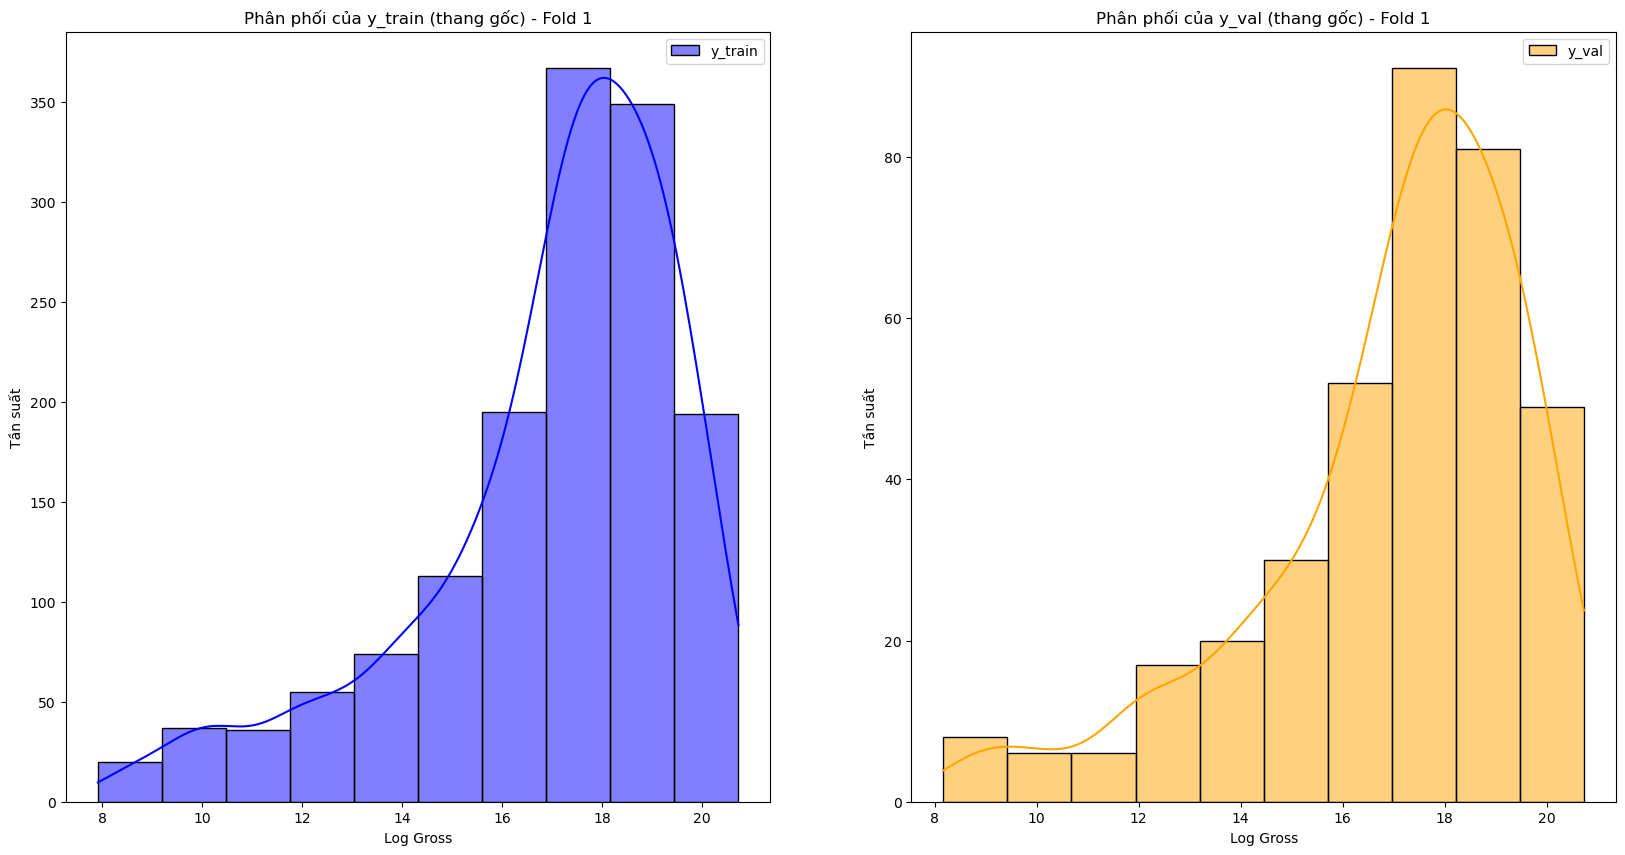

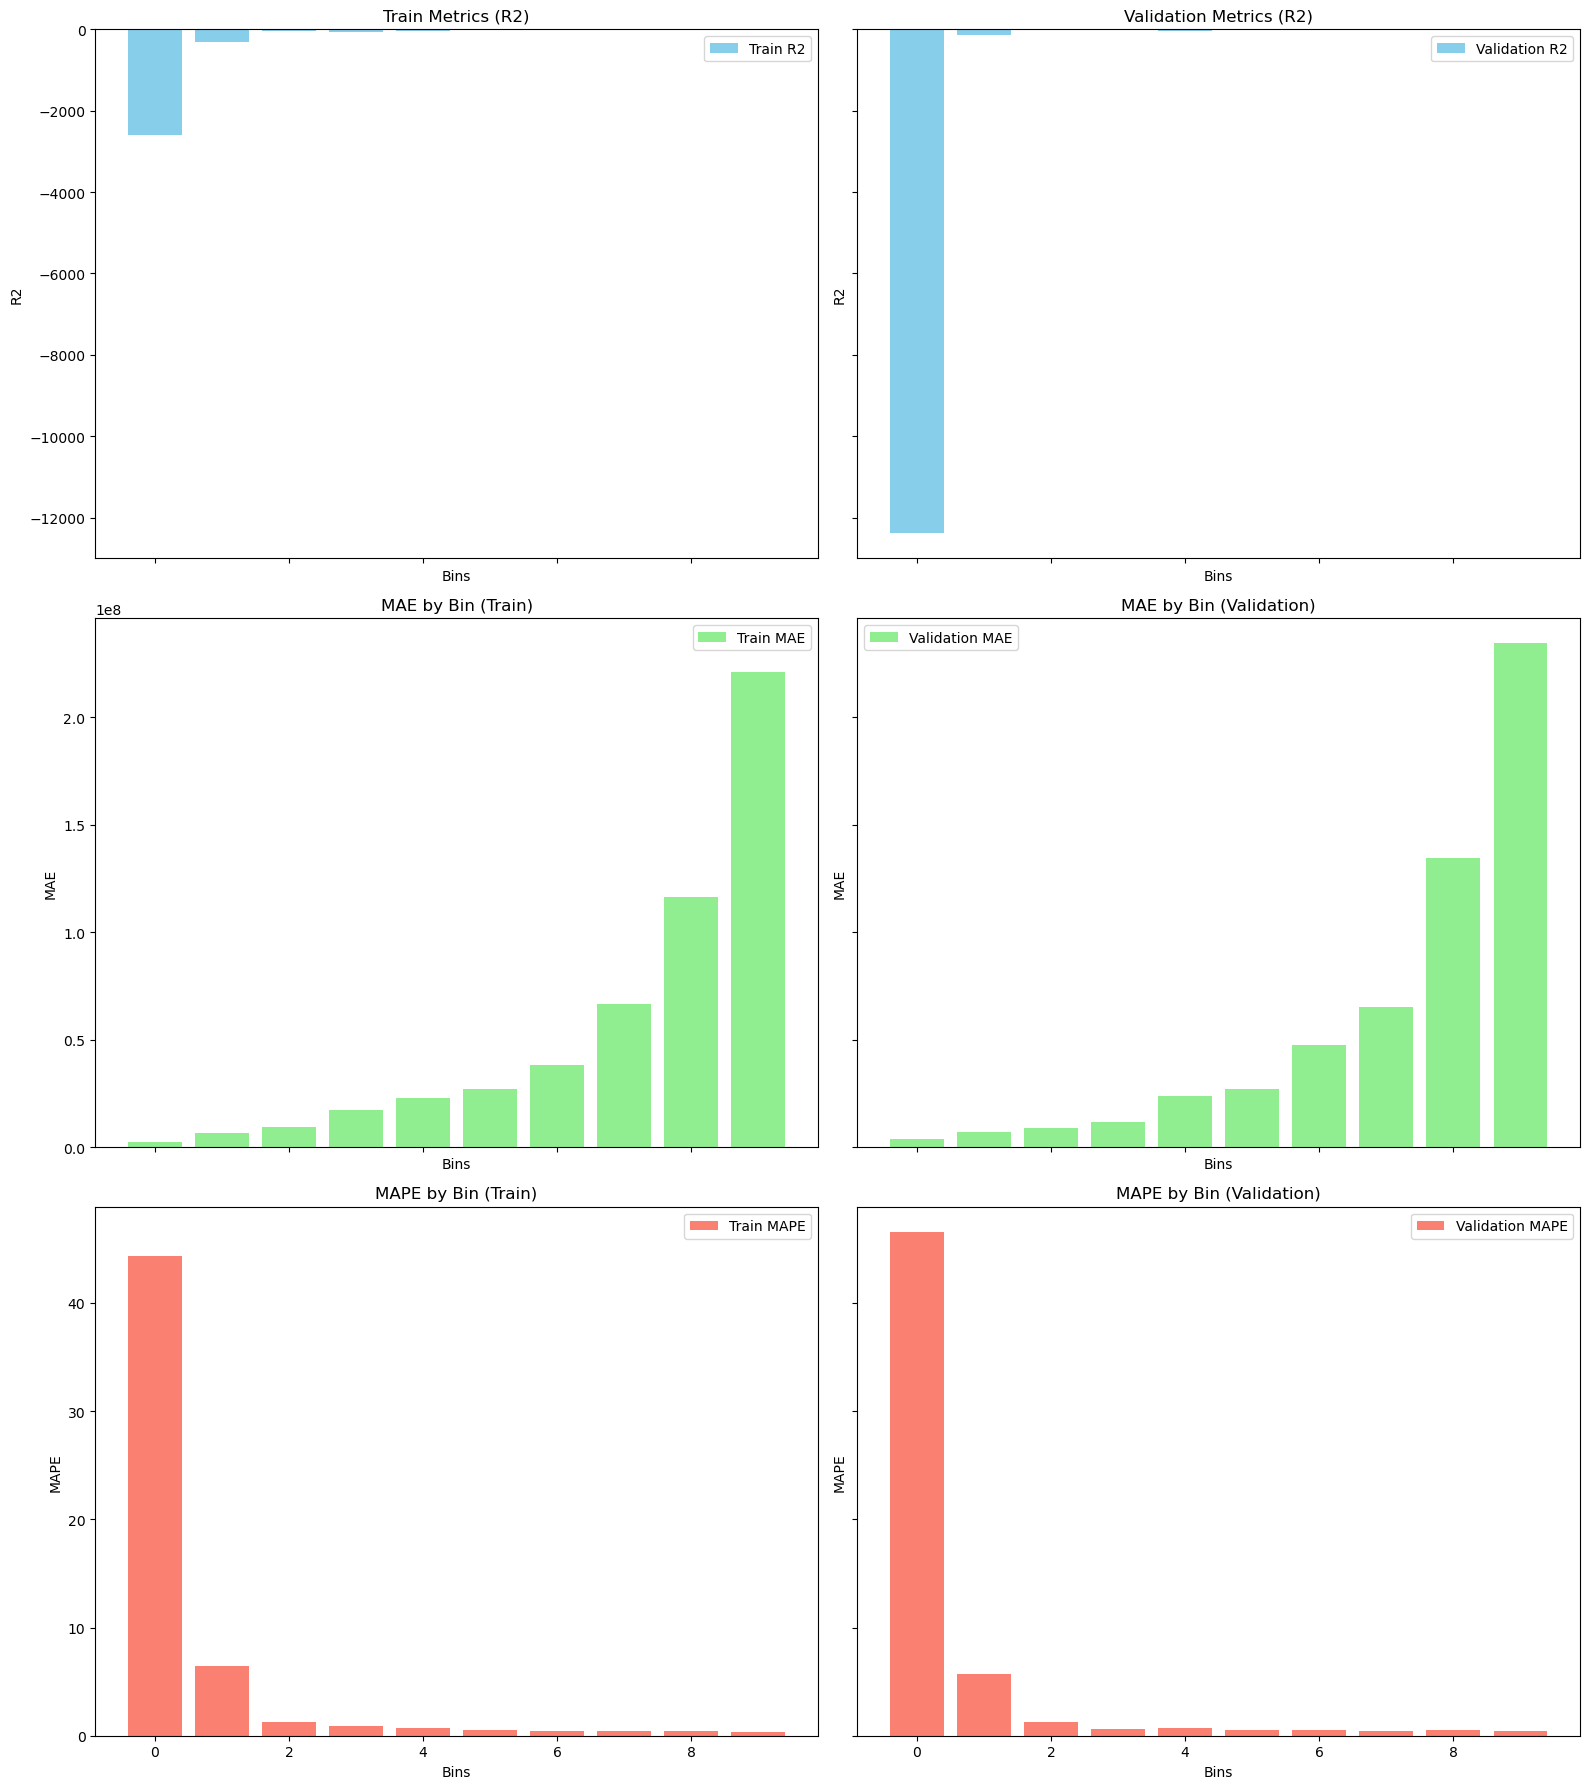

   Bin           R2           MAE       MAPE
0    0 -2590.554462  2.164131e+06  44.298332
1    1  -304.818102  6.685650e+06   6.449835
2    2   -34.253469  9.412172e+06   1.274891
3    3   -57.988510  1.705627e+07   0.885941
4    4   -30.066409  2.267358e+07   0.675230
5    5   -22.903875  2.721425e+07   0.500695
6    6   -11.234740  3.820342e+07   0.423997
7    7   -11.106577  6.650743e+07   0.430799
8    8    -8.201829  1.164193e+08   0.443534
9    9    -1.110830  2.209271e+08   0.376665
   Bin            R2           MAE       MAPE
0    0 -12381.607928  3.575992e+06  46.566539
1    1   -131.441344  6.942224e+06   5.684410
2    2    -24.781885  8.808194e+06   1.250292
3    3    -16.536550  1.149463e+07   0.612124
4    4    -29.340940  2.383844e+07   0.690951
5    5    -15.925755  2.717538e+07   0.512843
6    6    -14.437726  4.762536e+07   0.551626
7    7     -9.076113  6.537587e+07   0.426626
8    8     -7.643146  1.346953e+08   0.493837
9    9     -2.086463  2.344426e+08   0.417390

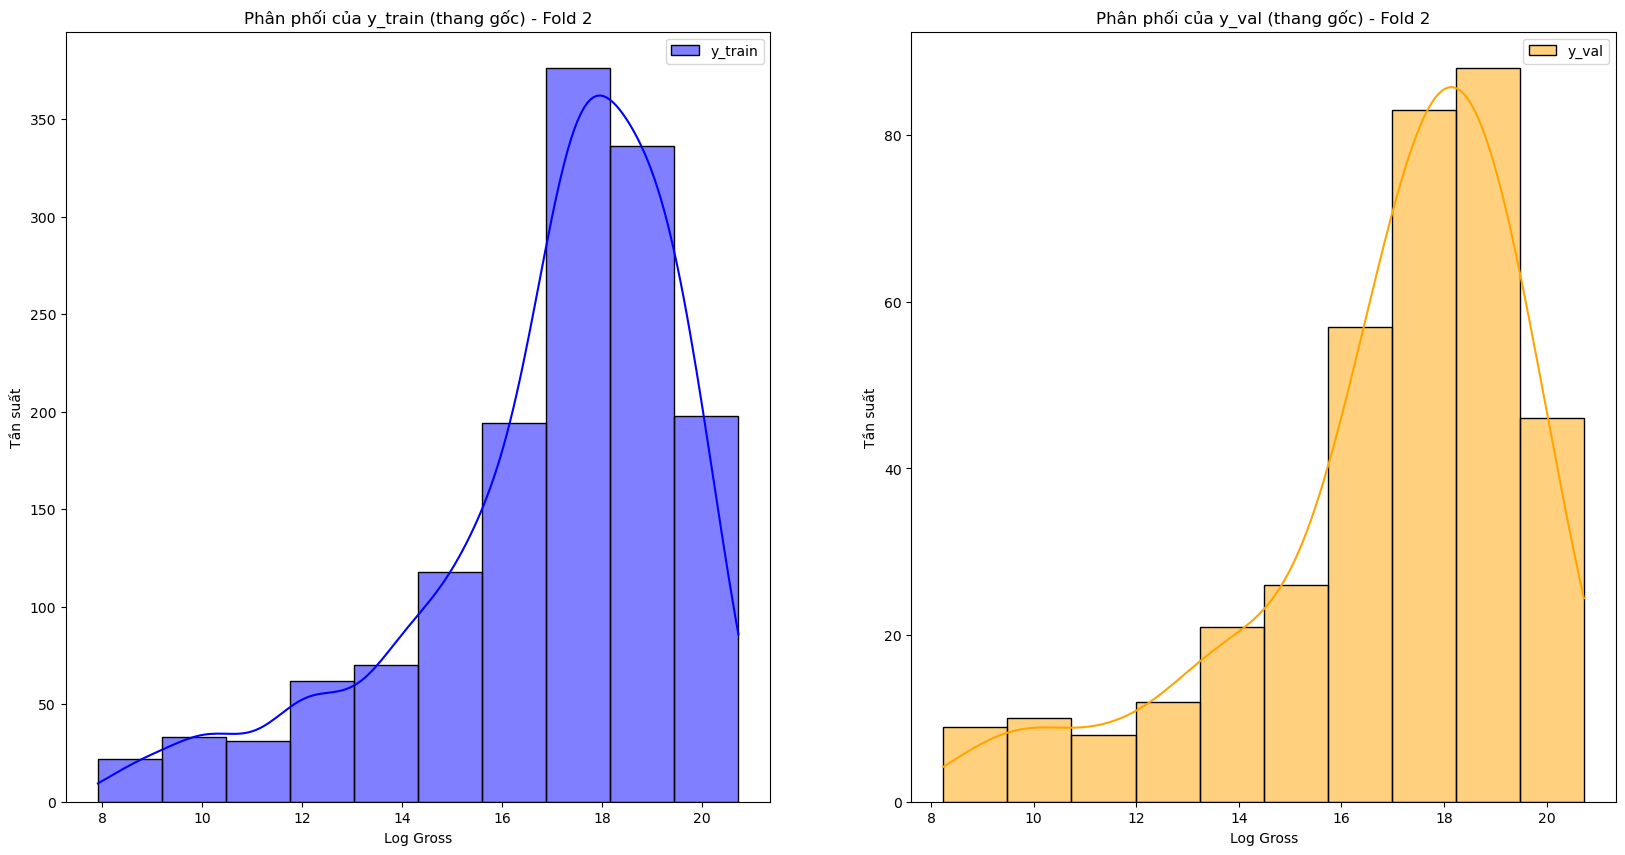

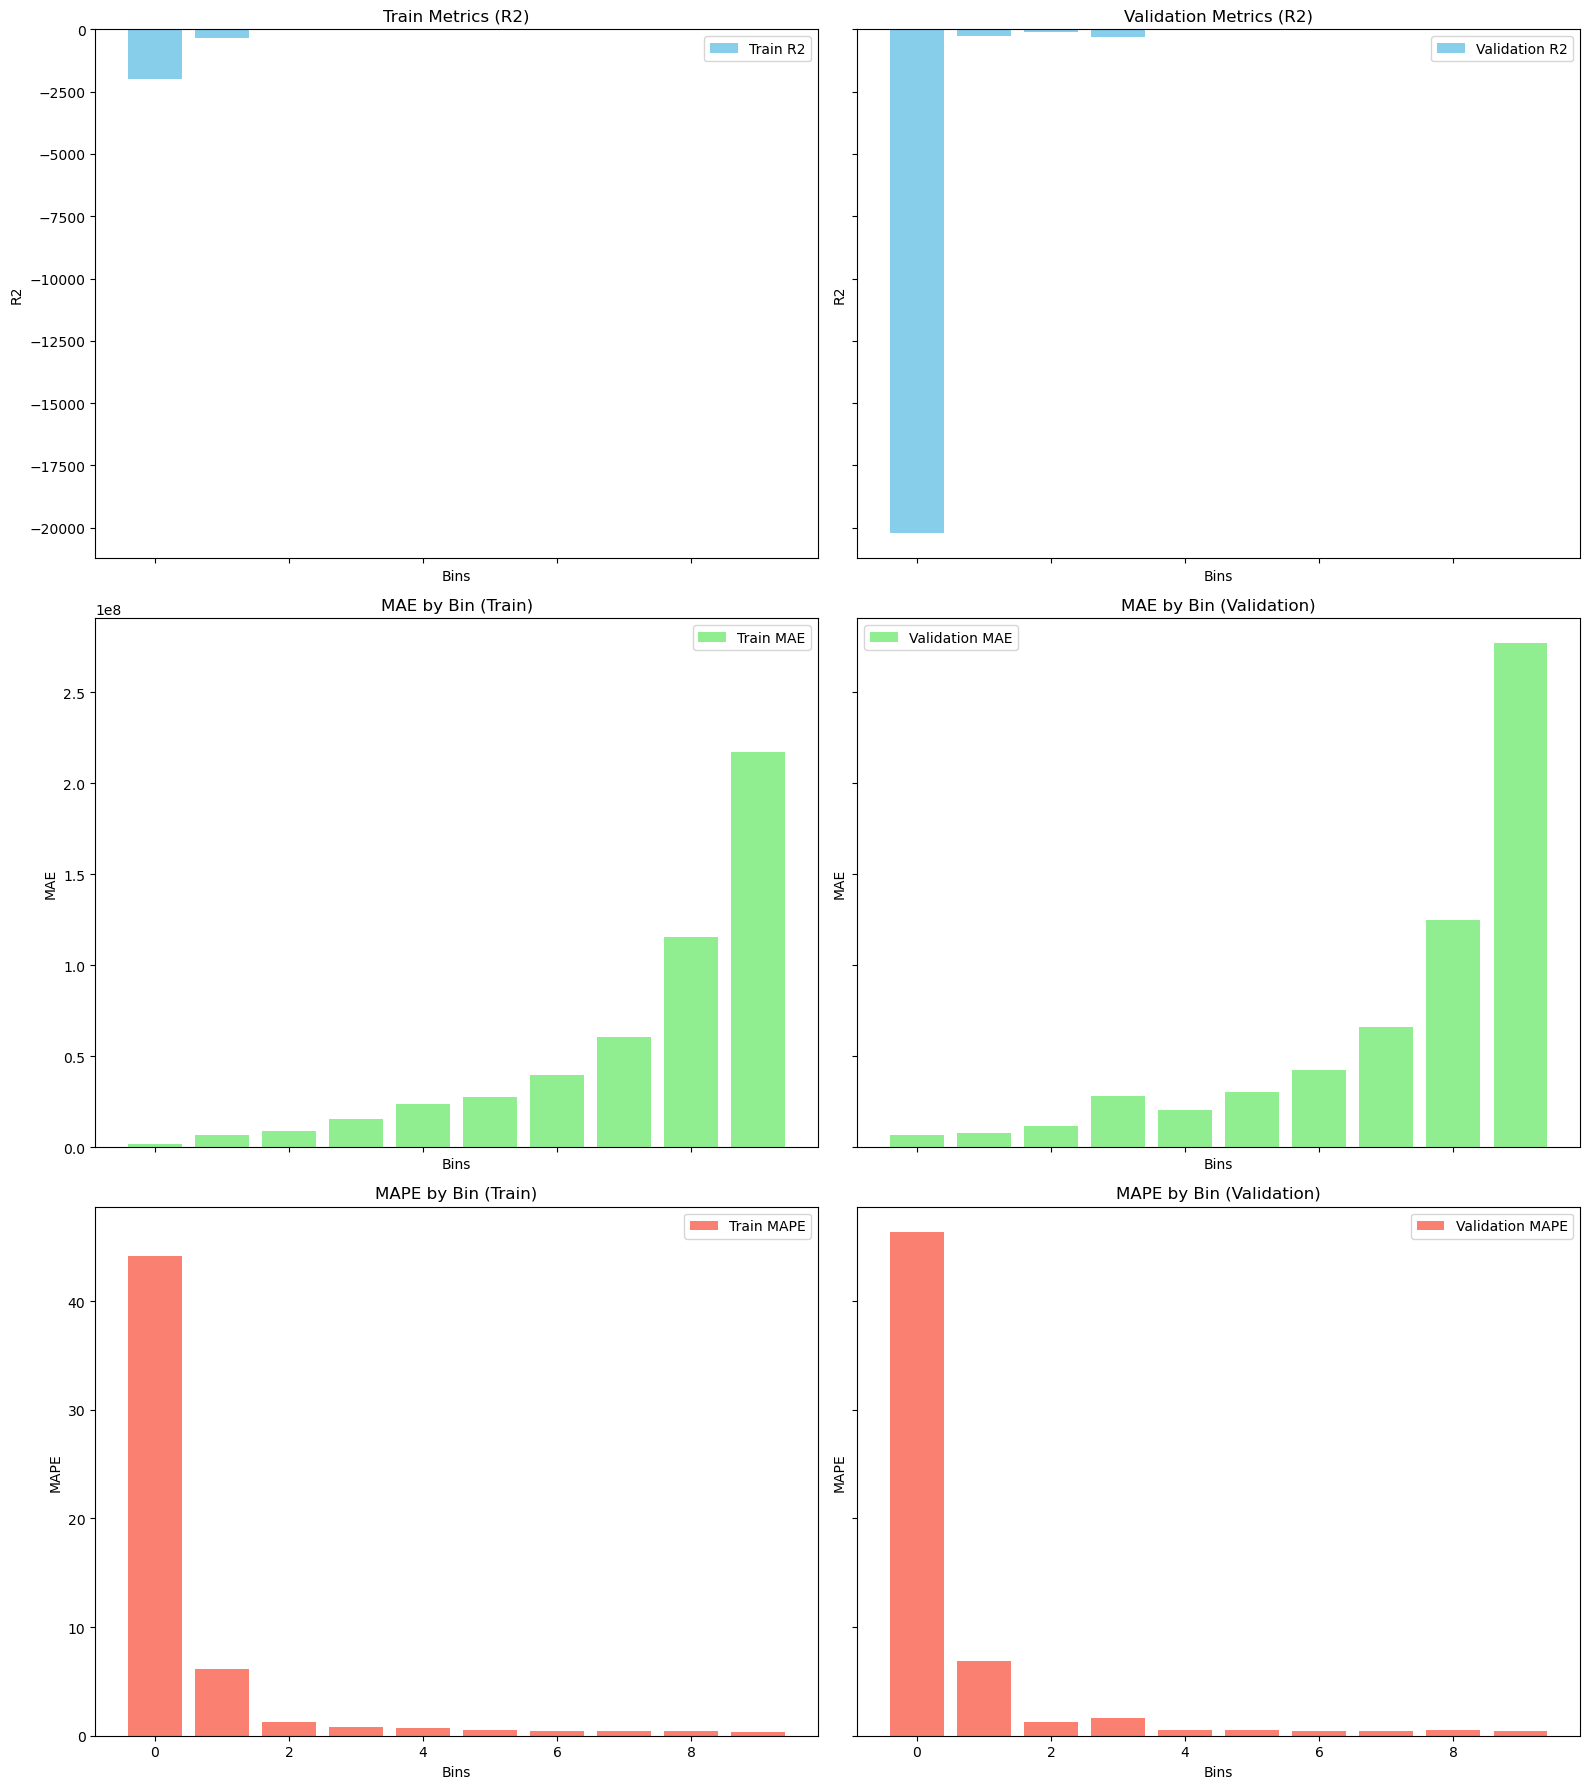

   Bin           R2           MAE       MAPE
0    0 -1989.640371  1.831786e+06  44.125328
1    1  -332.157942  6.454830e+06   6.163225
2    2   -28.530433  8.871720e+06   1.268262
3    3   -39.474932  1.551827e+07   0.787434
4    4   -34.915765  2.372138e+07   0.707241
5    5   -23.969189  2.762069e+07   0.512043
6    6   -10.693266  3.957797e+07   0.448296
7    7    -8.767685  6.067405e+07   0.390737
8    8    -7.395822  1.154461e+08   0.431456
9    9    -1.404881  2.171953e+08   0.374627
   Bin            R2           MAE       MAPE
0    0 -20214.948940  6.444604e+06  46.377542
1    1   -253.419354  7.689163e+06   6.858492
2    2   -113.798421  1.181777e+07   1.236243
3    3   -314.521804  2.817545e+07   1.608508
4    4    -22.365766  2.016433e+07   0.556026
5    5    -20.450301  3.037922e+07   0.547477
6    6    -14.971680  4.228067e+07   0.460991
7    7     -9.708255  6.605064e+07   0.444175
8    8     -9.966122  1.250869e+08   0.487718
9    9     -1.208790  2.769885e+08   0.455158

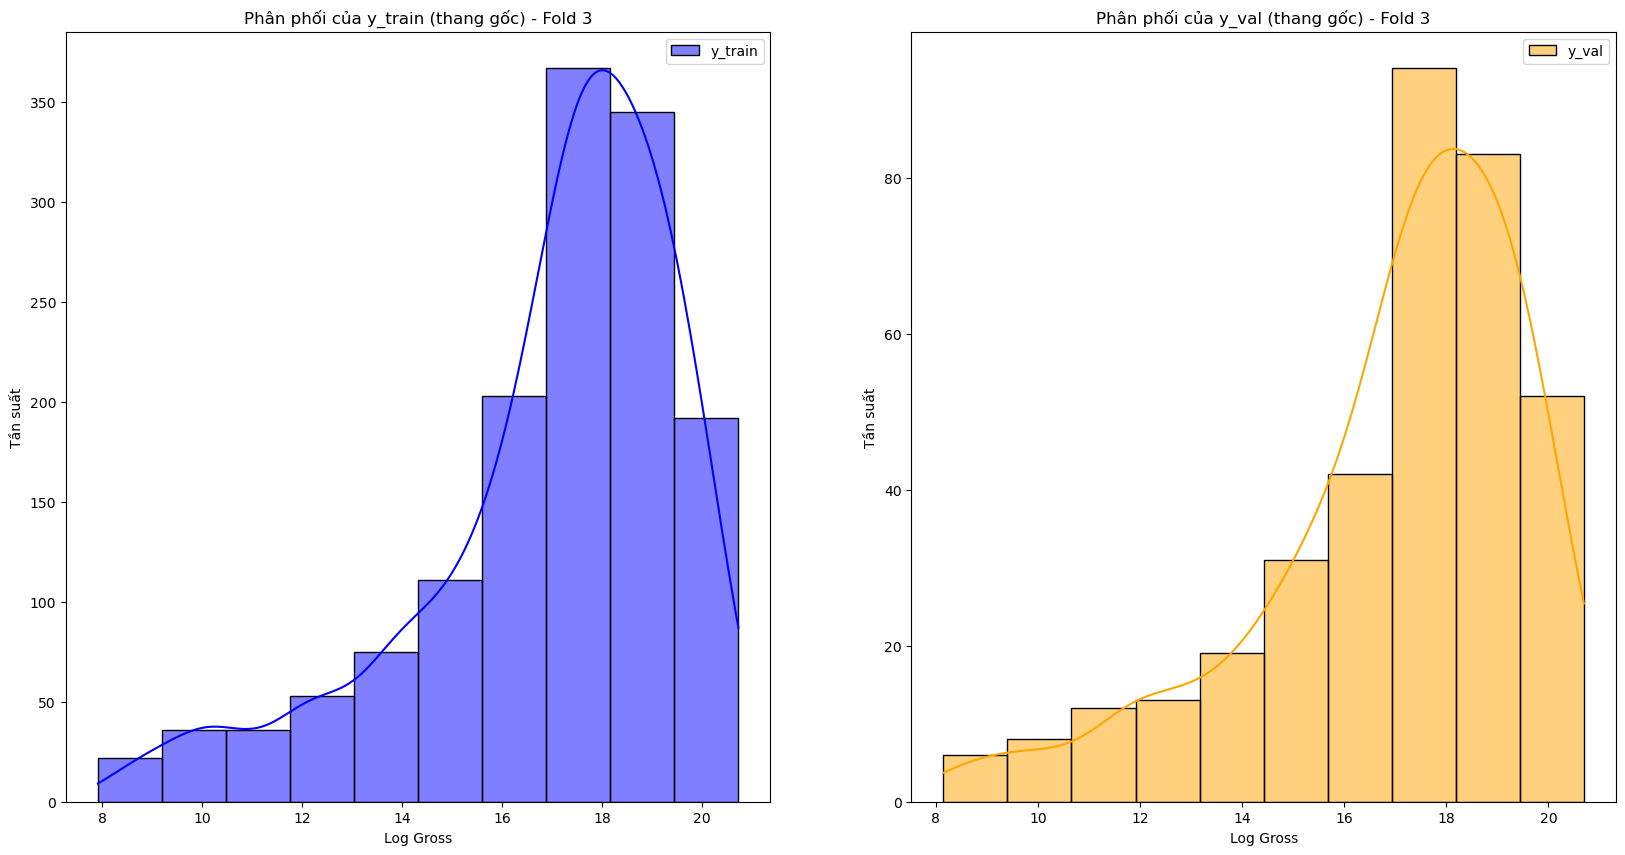

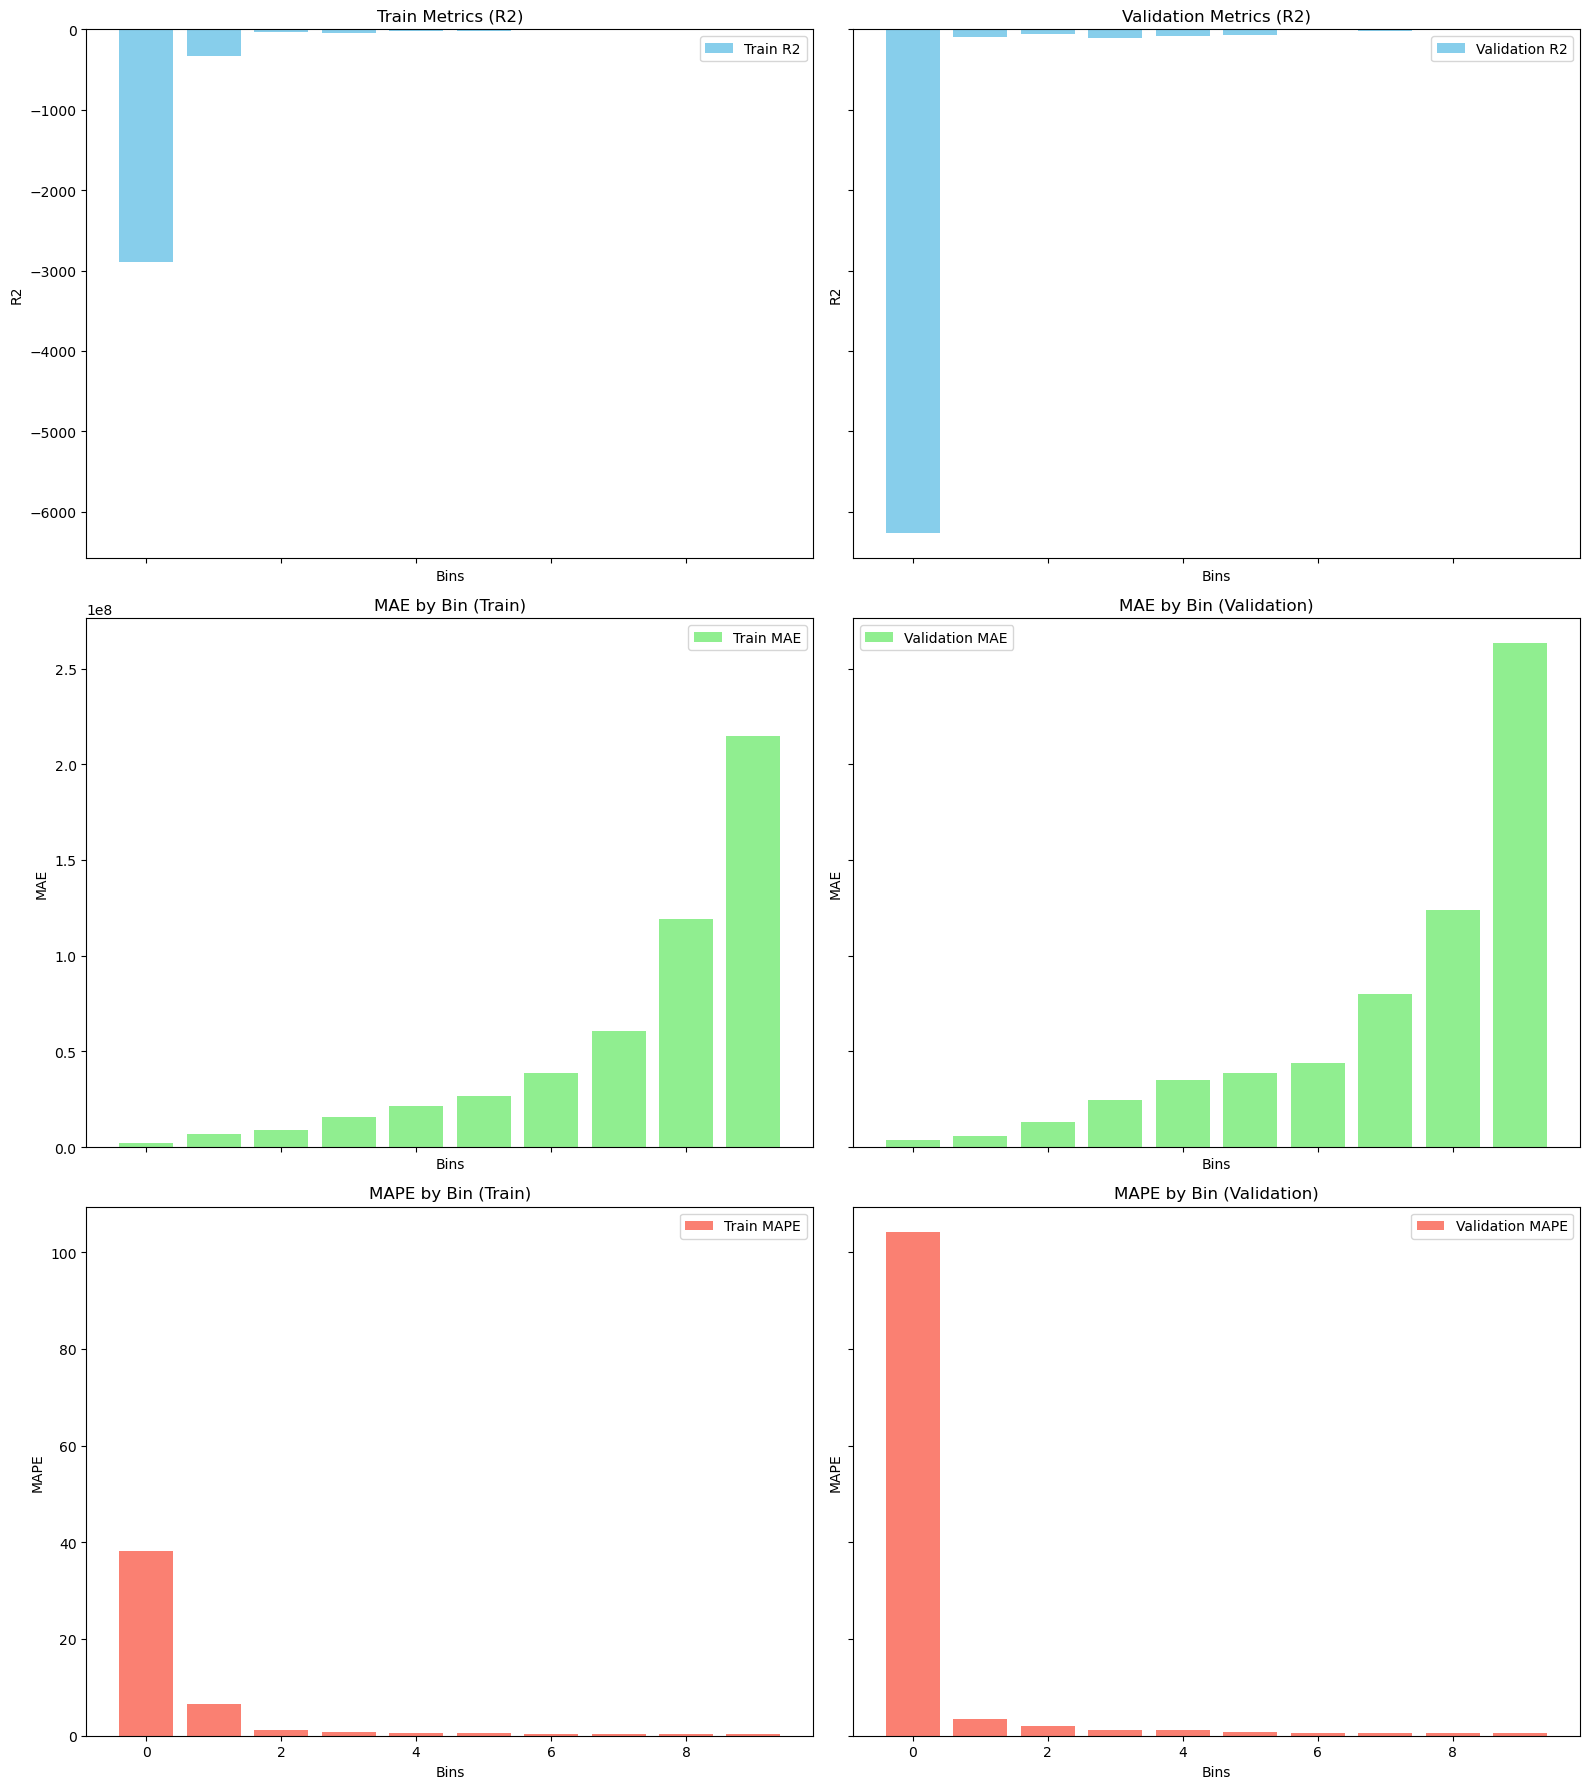

   Bin           R2           MAE       MAPE
0    0 -2896.425991  2.158704e+06  38.296254
1    1  -330.022942  6.637085e+06   6.516413
2    2   -29.619935  8.760961e+06   1.168447
3    3   -48.571208  1.573825e+07   0.841182
4    4   -25.784397  2.137399e+07   0.623842
5    5   -17.876222  2.685269e+07   0.498417
6    6   -10.887374  3.868135e+07   0.434717
7    7    -9.704019  6.067015e+07   0.399782
8    8    -7.773451  1.188823e+08   0.448634
9    9    -1.101986  2.149594e+08   0.369171
   Bin           R2           MAE        MAPE
0    0 -6265.945033  3.770288e+06  104.165421
1    1   -96.699528  5.842356e+06    3.406802
2    2   -61.105495  1.313354e+07    2.006631
3    3  -103.604761  2.459309e+07    1.210720
4    4   -87.335525  3.491828e+07    1.102409
5    5   -71.537342  3.858884e+07    0.704366
6    6   -14.290270  4.397248e+07    0.487975
7    7   -15.248372  7.984150e+07    0.489803
8    8    -9.226588  1.236311e+08    0.465346
9    9    -1.983458  2.632120e+08    0.472280

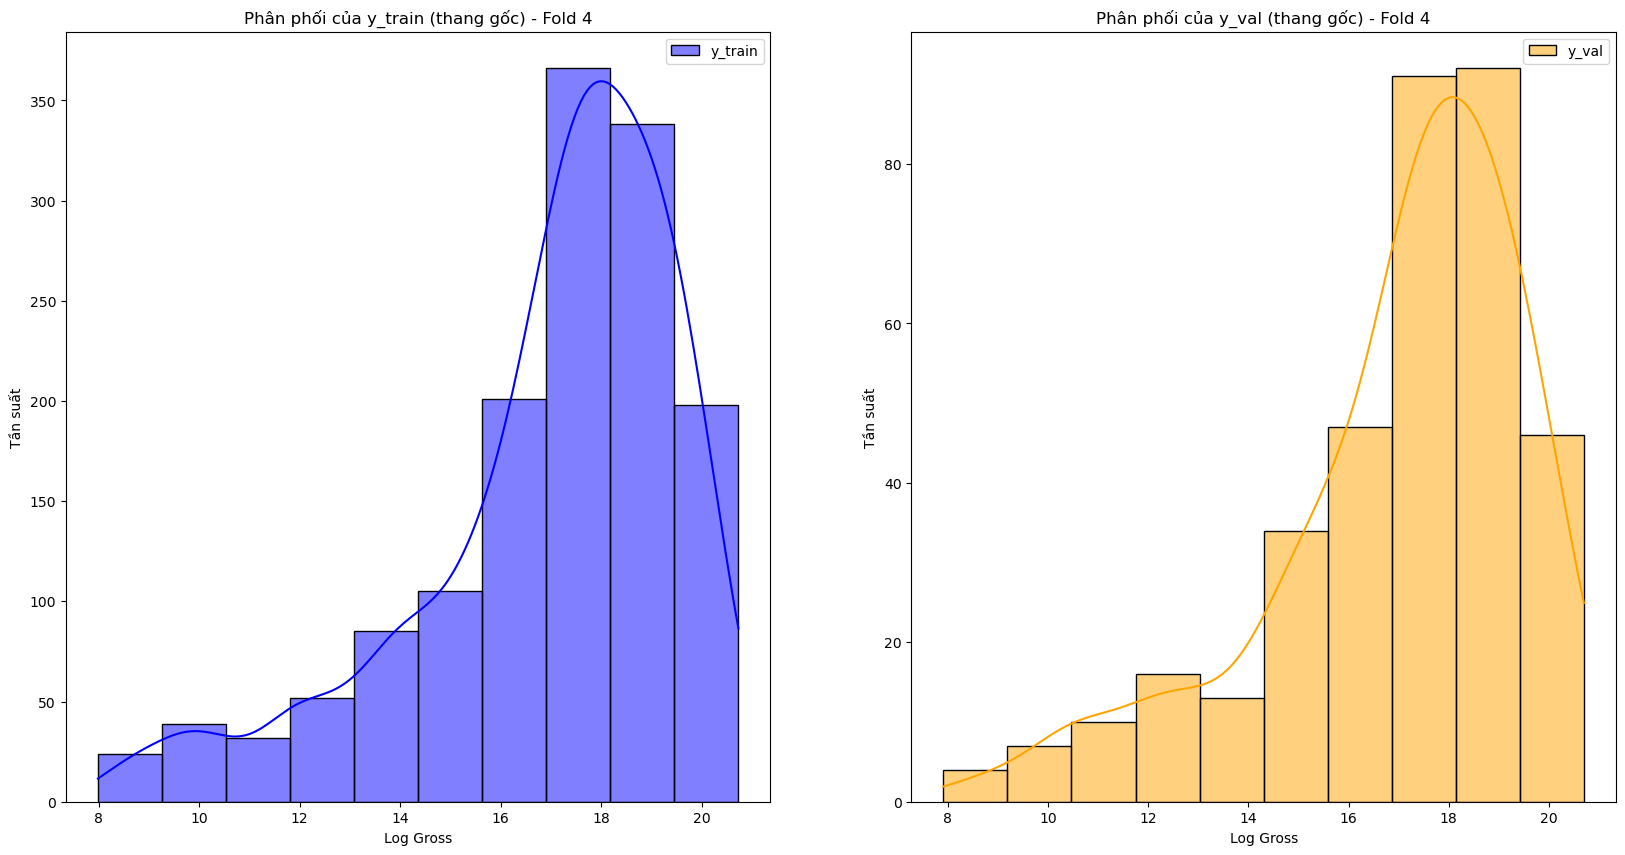

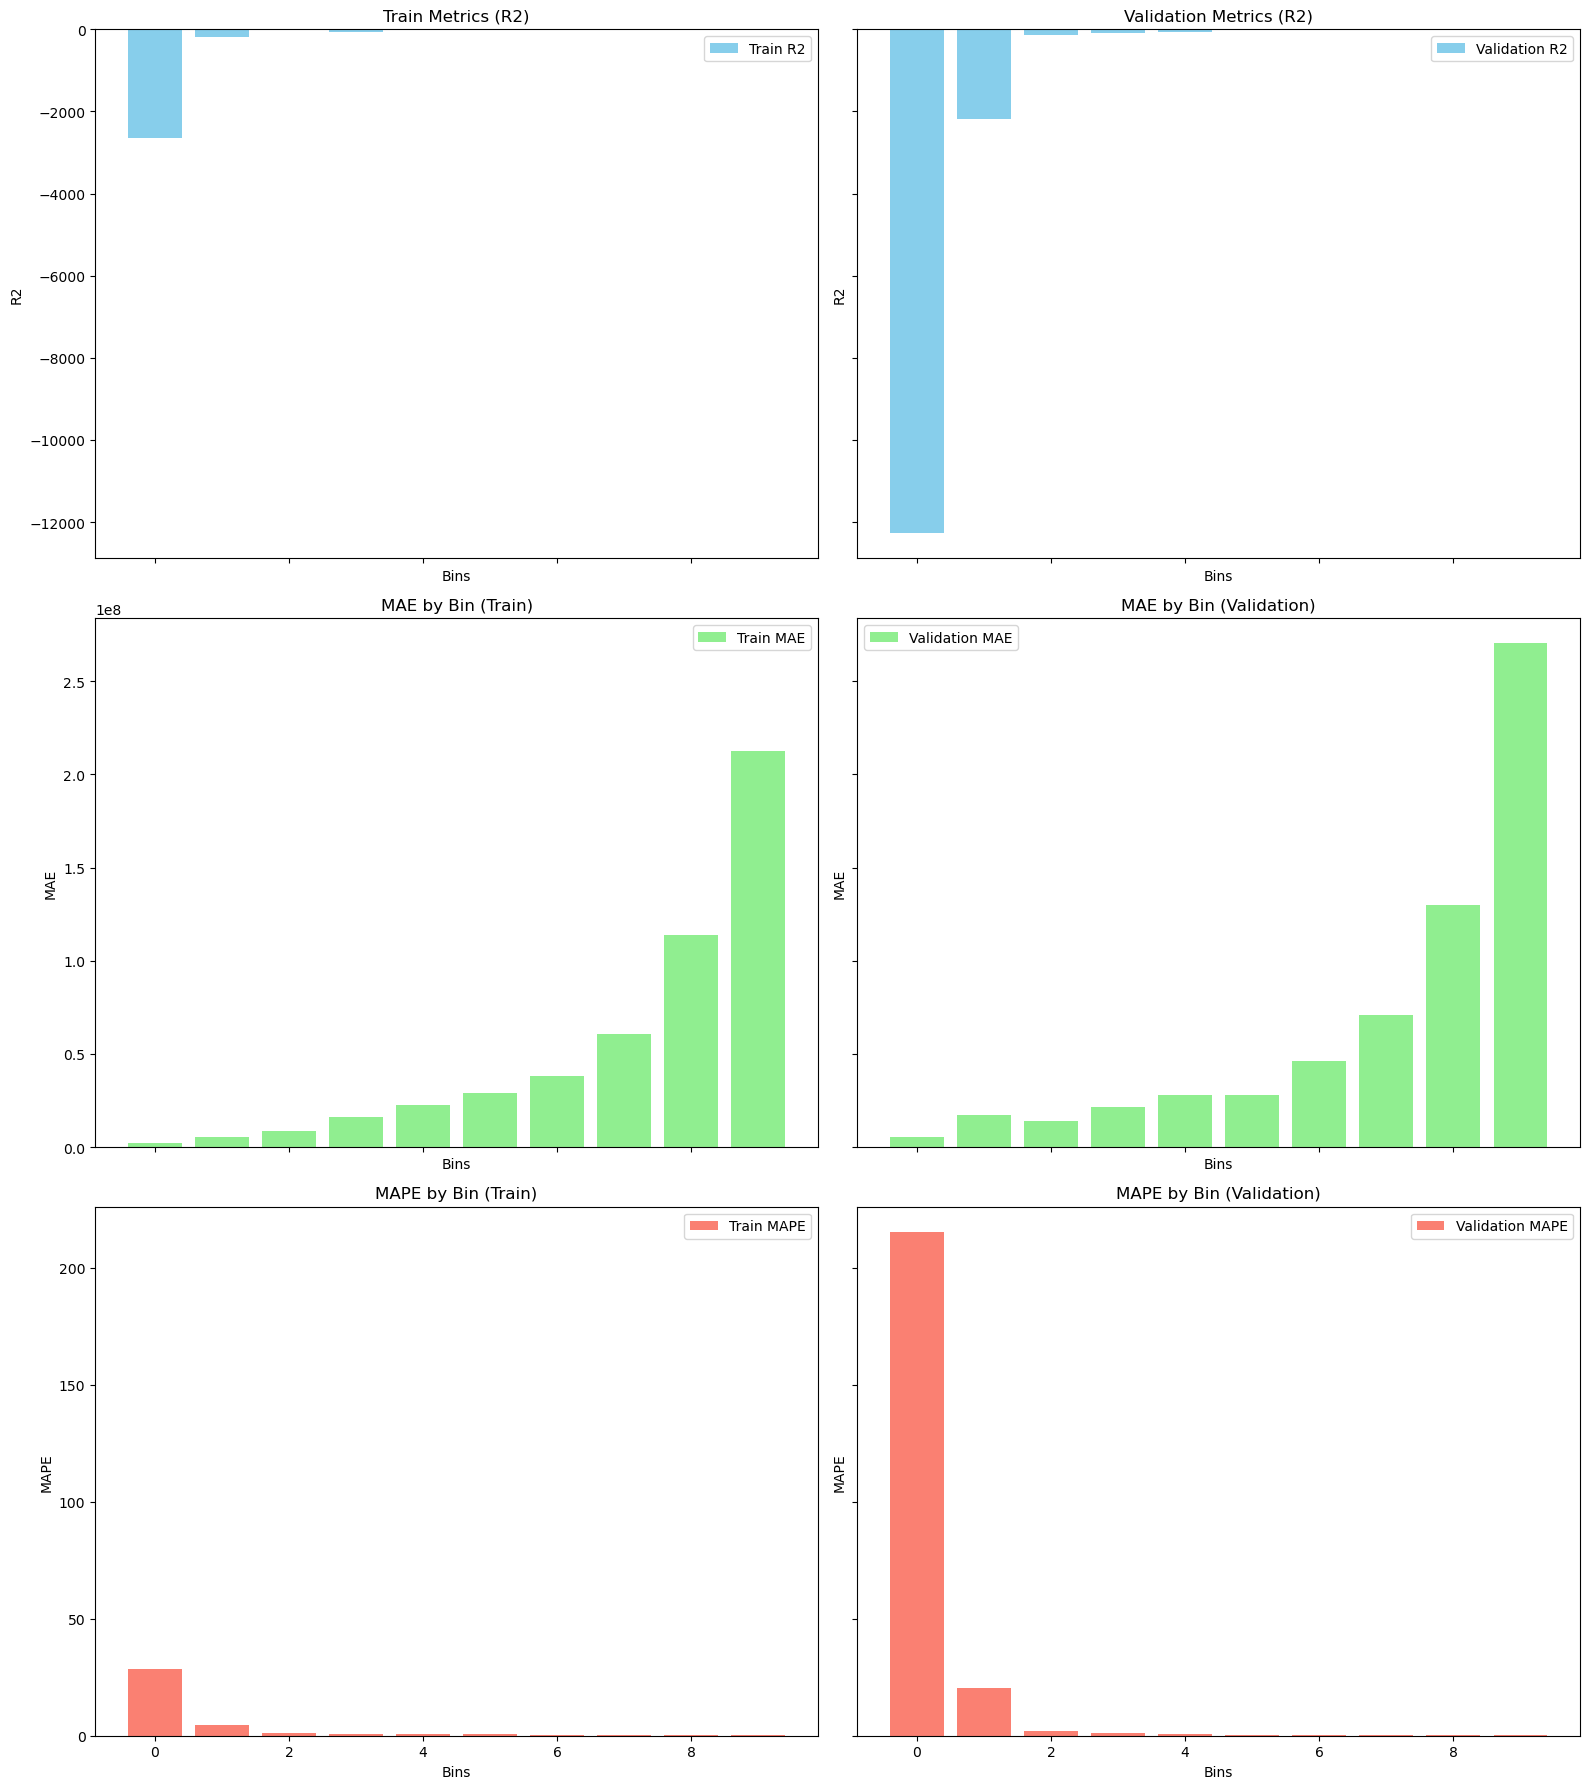

   Bin           R2           MAE       MAPE
0    0 -2643.272235  2.073224e+06  28.461869
1    1  -180.591879  5.451763e+06   4.739415
2    2   -27.187622  8.733195e+06   1.190977
3    3   -59.274500  1.609387e+07   0.859244
4    4   -28.290124  2.242857e+07   0.659024
5    5   -25.810733  2.902180e+07   0.537581
6    6    -9.800396  3.813934e+07   0.427279
7    7    -8.444259  6.046737e+07   0.390876
8    8    -7.100137  1.136548e+08   0.422357
9    9    -1.058292  2.122982e+08   0.370866
   Bin            R2           MAE        MAPE
0    0 -12268.242938  5.181982e+06  215.377972
1    1  -2183.293569  1.702714e+07   20.392255
2    2   -147.427139  1.408396e+07    1.925509
3    3    -94.554474  2.170015e+07    1.052173
4    4    -68.779409  2.799385e+07    0.839213
5    5    -18.133838  2.766093e+07    0.504296
6    6    -17.626930  4.592308e+07    0.519875
7    7    -20.146689  7.098140e+07    0.466821
8    8    -10.935600  1.298443e+08    0.509947
9    9     -1.987537  2.703897e+08 

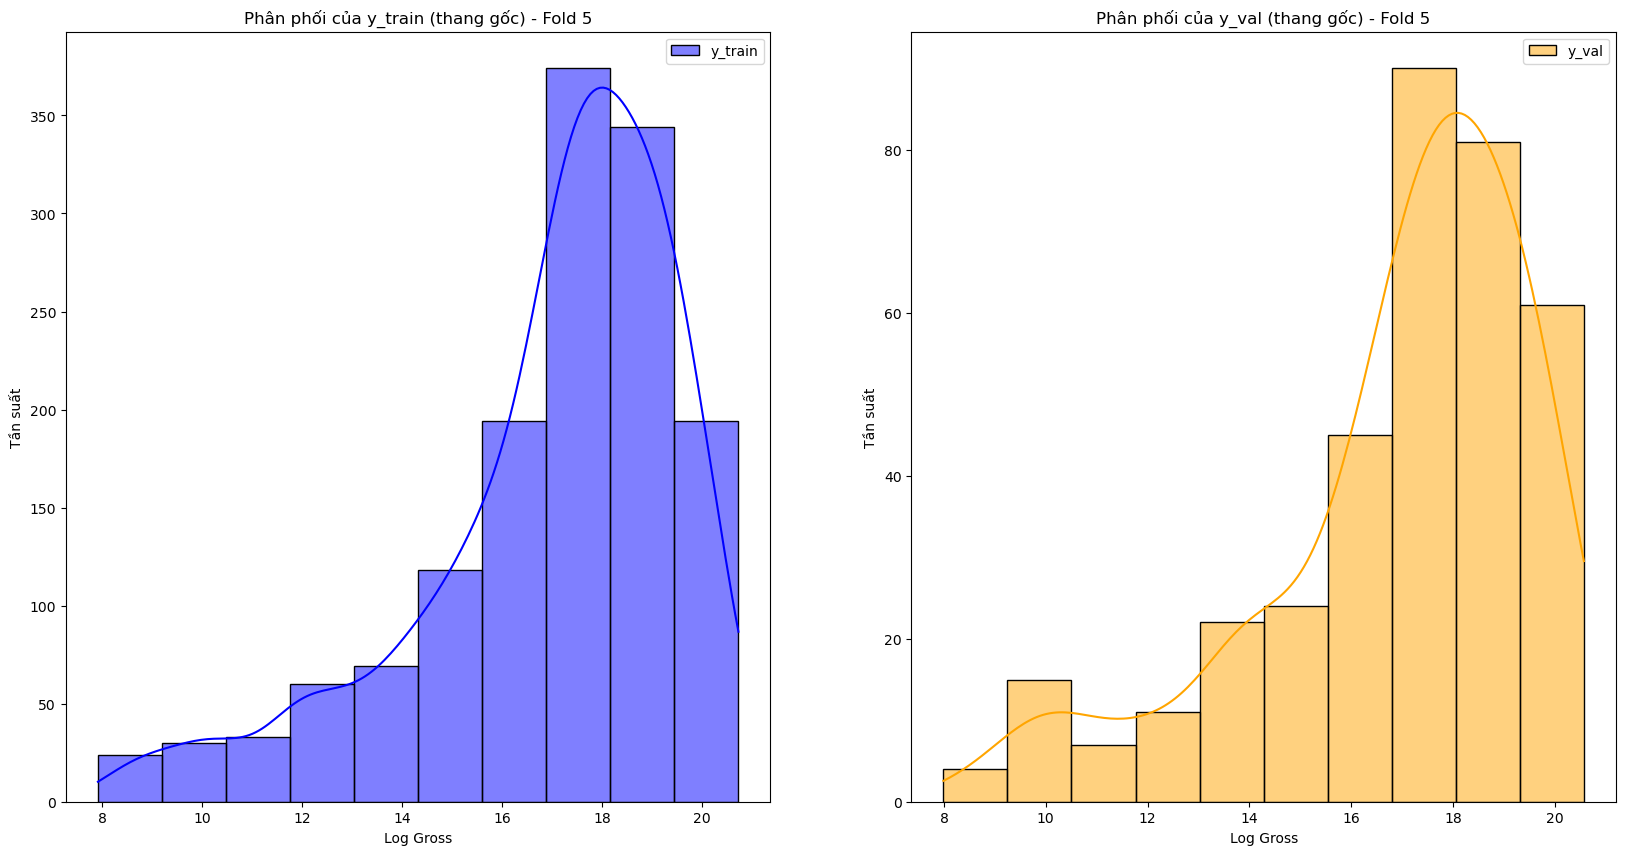

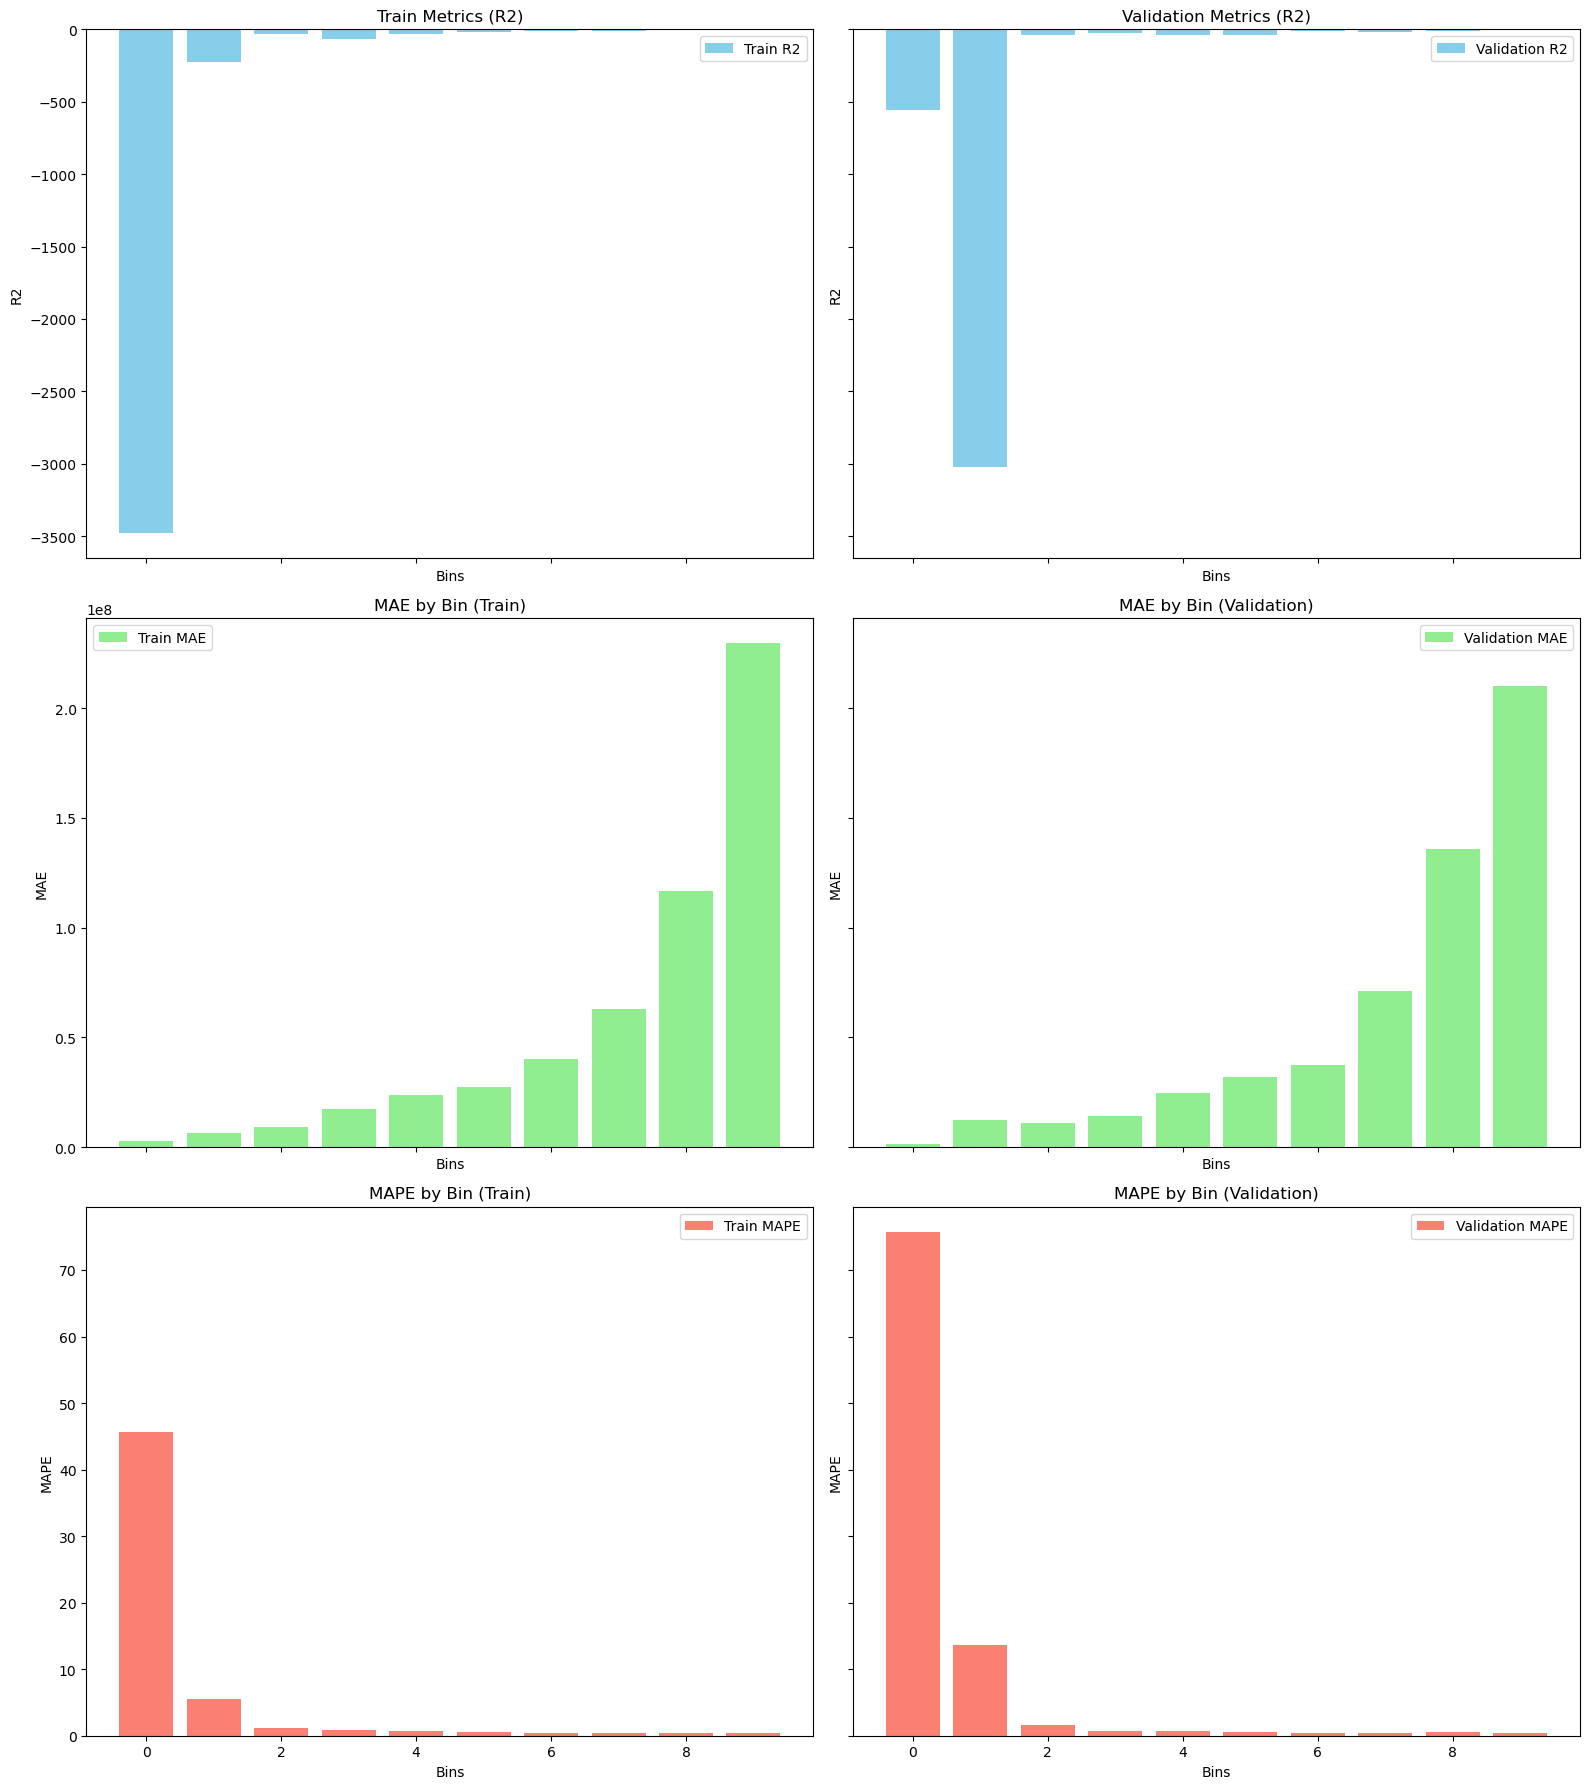

   Bin           R2           MAE       MAPE
0    0 -3478.998729  2.558530e+06  45.699746
1    1  -226.113909  6.190125e+06   5.514674
2    2   -33.887407  8.969334e+06   1.216725
3    3   -63.656254  1.732073e+07   0.904037
4    4   -31.475738  2.355784e+07   0.697797
5    5   -19.750154  2.718495e+07   0.499171
6    6   -11.617116  4.013847e+07   0.451598
7    7    -9.264988  6.305383e+07   0.406869
8    8    -7.518890  1.168684e+08   0.445670
9    9    -1.150151  2.295710e+08   0.395836
   Bin           R2           MAE       MAPE
0    0  -555.537285  1.466146e+06  75.717590
1    1 -3022.929704  1.210877e+07  13.694566
2    2   -41.866459  1.100560e+07   1.659094
3    3   -22.958897  1.412400e+07   0.771389
4    4   -37.407550  2.449914e+07   0.713390
5    5   -41.436800  3.200378e+07   0.612360
6    6    -9.239910  3.759727e+07   0.414996
7    7   -18.071528  7.093372e+07   0.463007
8    8   -10.685018  1.357603e+08   0.488440
9    9    -1.866283  2.101669e+08   0.359664
Avg r2 tra

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from evaluation import visualize_results
from settings import FEATURES, TARGET
import matplotlib.pyplot as plt

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
overall_r2_trains = []
overall_mae_trains = []
overall_mape_trains = []

overall_r2_vals = []
overall_mae_vals = []
overall_mape_vals = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['log_gross_bin'])):
    print(f"\n Fold {fold + 1}")
    df_train = df.iloc[train_idx].copy()
    df_val = df.iloc[val_idx].copy()

    X_train, y_train, X_val, y_val = processing_data(df_train, df_val, fold=fold,features=FEATURES, target=TARGET, model_name="random_forest")

    best_model = RandomForestRegressor(random_state=42, bootstrap=True, min_samples_leaf=10, min_samples_split=5, n_estimators=200, max_depth=10, max_features="sqrt")
    best_model.fit(X_train, y_train)

    

    train_preds = best_model.predict(X_train)
    val_preds = best_model.predict(X_val)

    df_train_processed = pd.DataFrame(X_train, columns=FEATURES)
    df_train_processed[TARGET] = y_train


    fig, axes = plt.subplots(3, 2, figsize=(16, 18), sharex=True, sharey='row')  # 3 rows (R2, MAE, MAPE), 2 columns (Train, Validation)

    # Gọi visualize_results cho tập Train và vẽ vào cột đầu tiên (Train)
    df_test_result, overall_r2_train, overall_mae_train, overall_train = visualize_results(df_train, y_true=y_train, y_pred=train_preds, calculate_real_target=True, dataset_label="Train", axes=axes[:, 0])
    overall_mape_trains.append(overall_mae_train)
    overall_r2_trains.append(overall_r2_train)
    overall_mae_trains.append(overall_mae_train)

    # Gọi visualize_results cho tập Validation và vẽ vào cột thứ hai (Validation)
    df_val_result, overall_r2_val, overall_mae_val, overall_mape_val = visualize_results(df_val, y_true=y_val, y_pred=val_preds, calculate_real_target=True, dataset_label="Validation", axes=axes[:, 1])
    overall_r2_vals.append(overall_r2_val)
    overall_mae_vals.append(overall_mae_val)
    overall_mape_vals.append(overall_mape_val)

    # Cài đặt tiêu đề và hiển thị
    axes[0, 0].set_title("Train Metrics (R2)")  # Tiêu đề cho R2 Train
    axes[0, 1].set_title("Validation Metrics (R2)")  # Tiêu đề cho R2 Validation

    plt.tight_layout()
    plt.show()
    print(df_test_result)
    print(df_val_result)

print("Avg r2 train: ", np.mean(overall_r2_trains))
print("Avg mae train: ", np.mean(overall_mae_trains))
print("Avg mape train: ", np.mean(overall_mape_trains))

print("Avg r2 val: ", np.mean(overall_r2_vals))
print("Avg mae val: ", np.mean(overall_mae_vals))
print("Avg map val: ", np.mean(overall_mape_vals))



#### Thư viện Optuna


Fold 1
 Best hyperparameters: {'n_estimators': 219, 'max_depth': None, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.490172278626588
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.8489
MAE: 34,068,352.0442
MAPE: 1.22%
Test Metrics
R2 score: 0.6017
MAE: 62,668,626.7987
MAPE: 10.25%


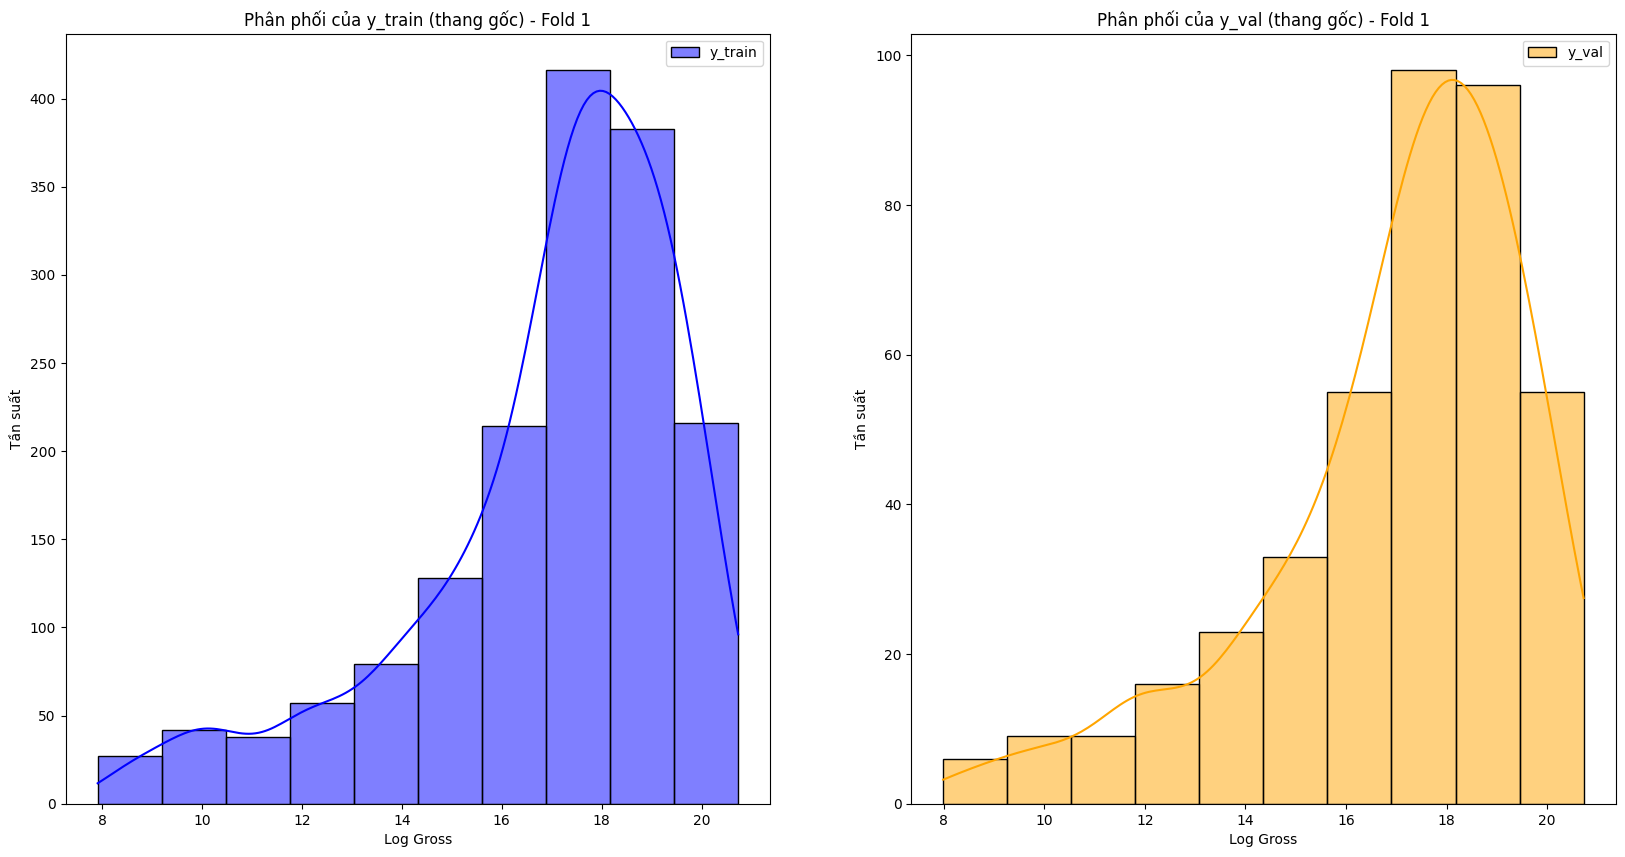

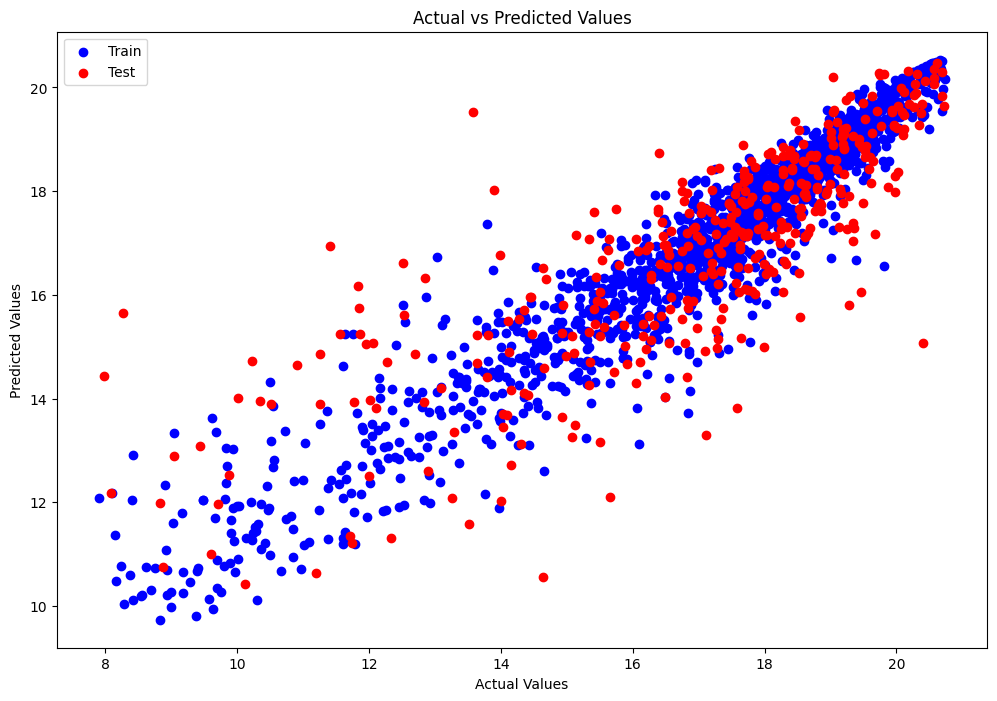

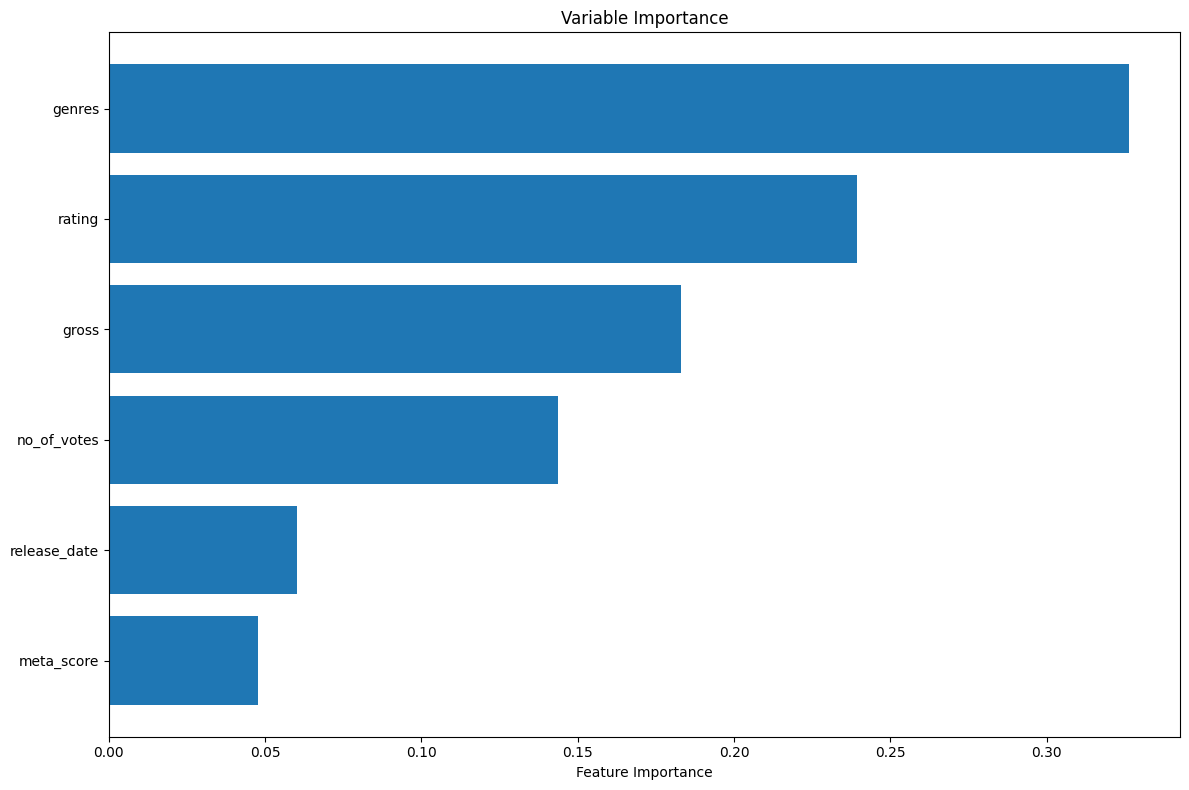


Fold 2
 Best hyperparameters: {'n_estimators': 278, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.5237134006091897
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.7527
MAE: 46,958,391.5045
MAPE: 3.09%
Test Metrics
R2 score: 0.5832
MAE: 64,628,264.6972
MAPE: 11.11%


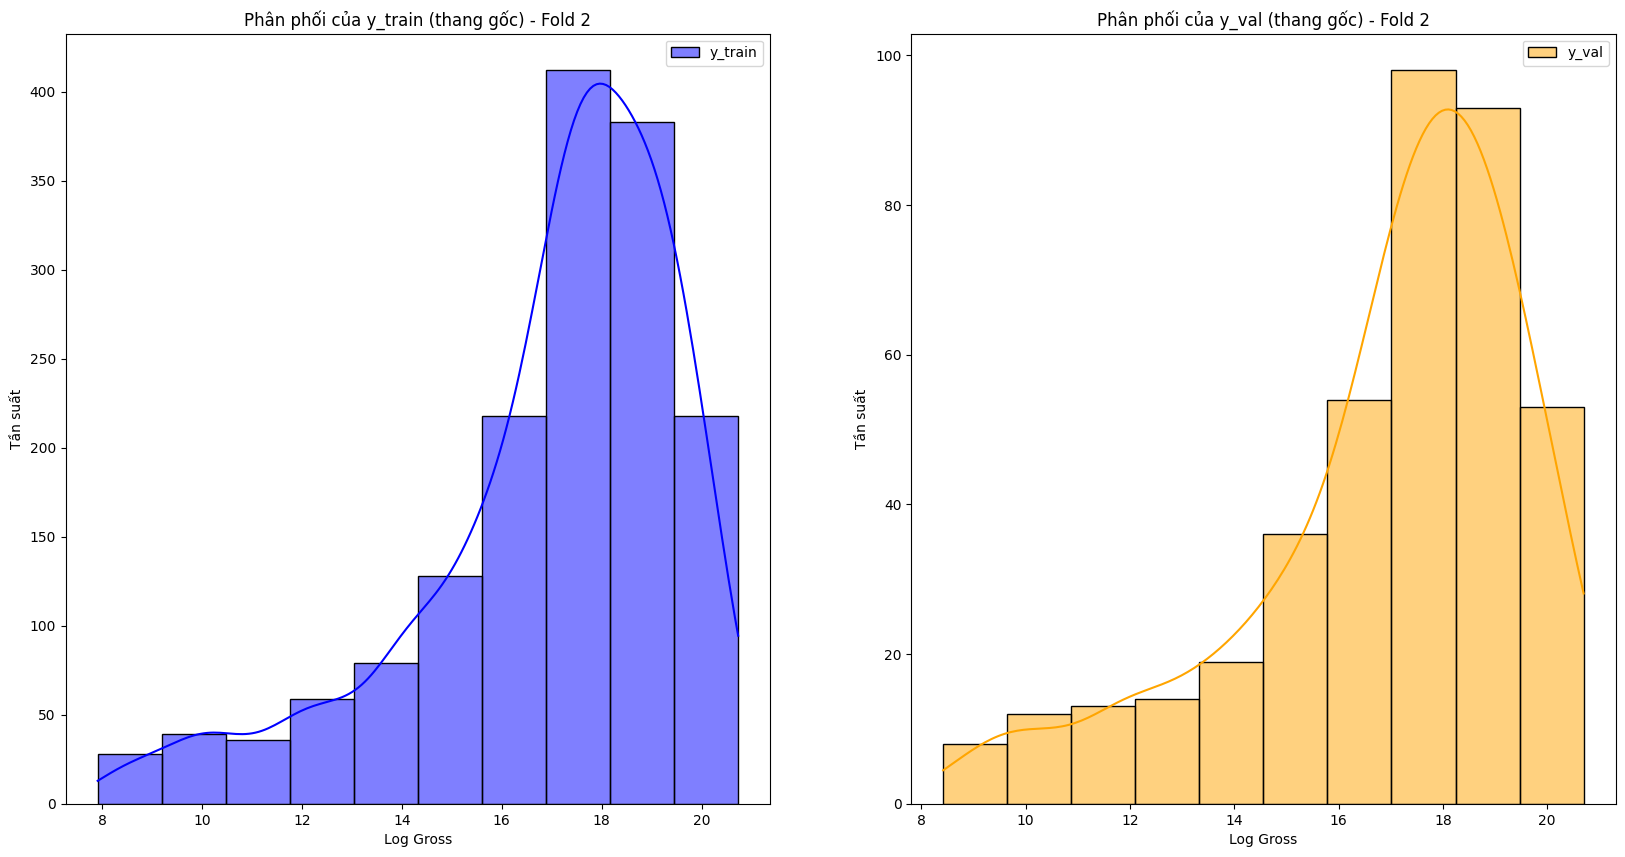

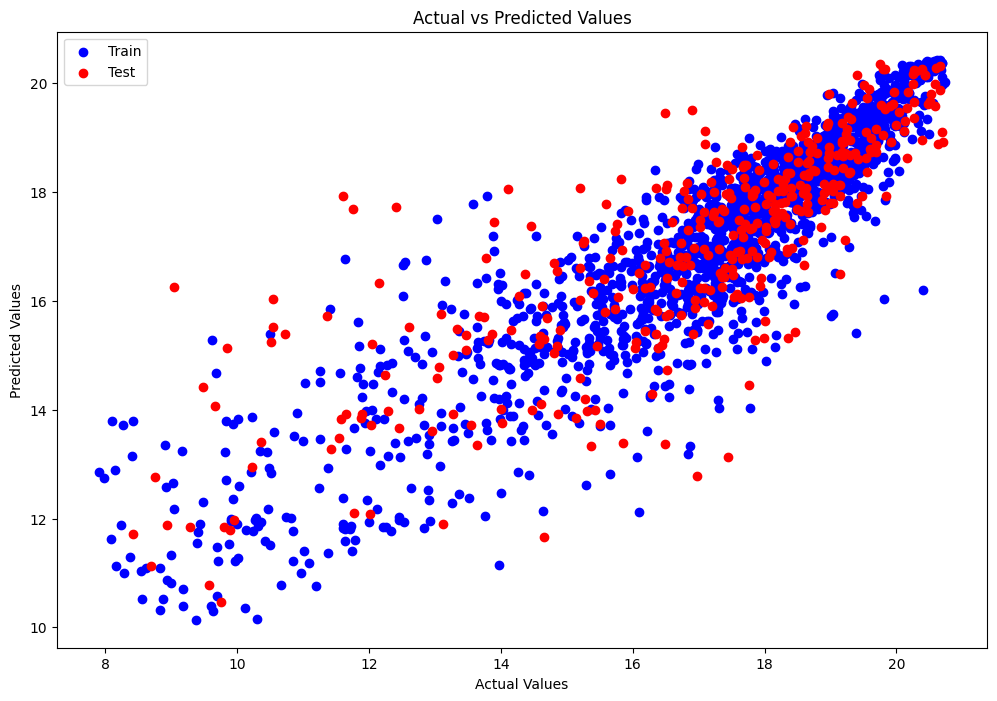

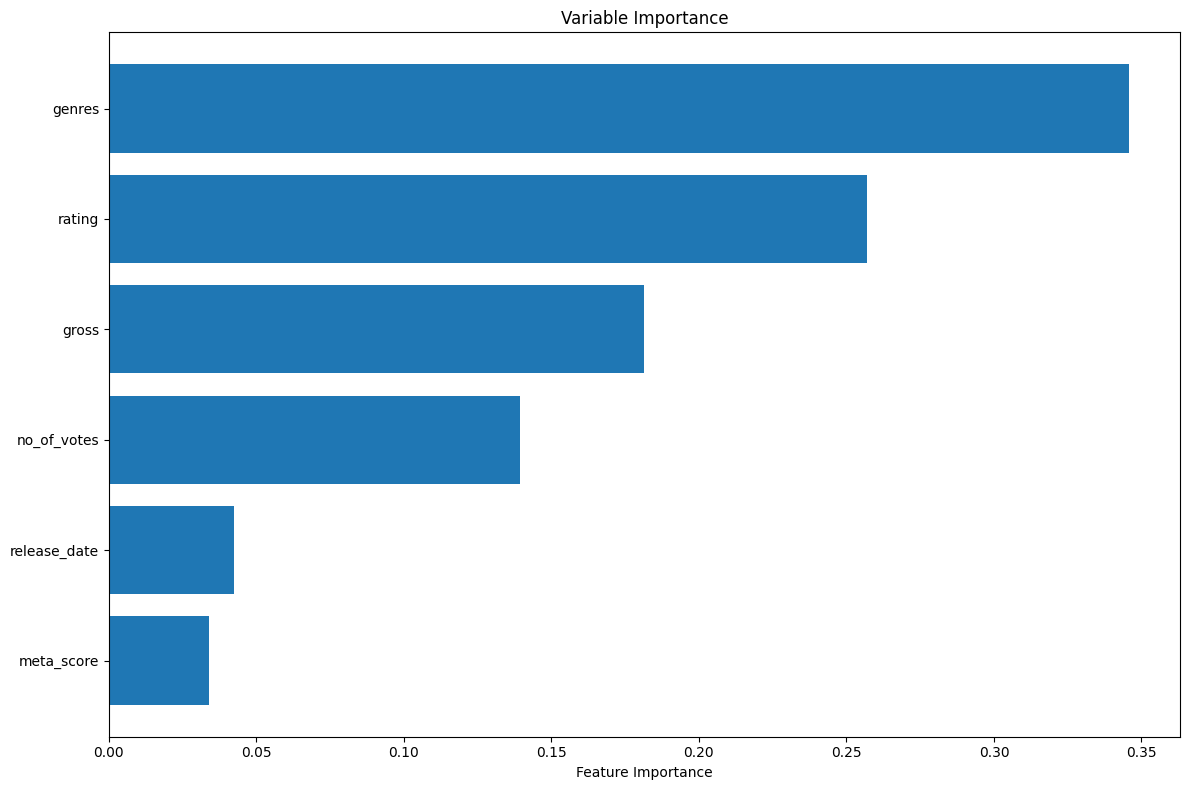


Fold 3
 Best hyperparameters: {'n_estimators': 333, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.360854331495268
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.8417
MAE: 34,915,582.1289
MAPE: 1.21%
Test Metrics
R2 score: 0.6925
MAE: 56,747,852.8386
MAPE: 21.20%


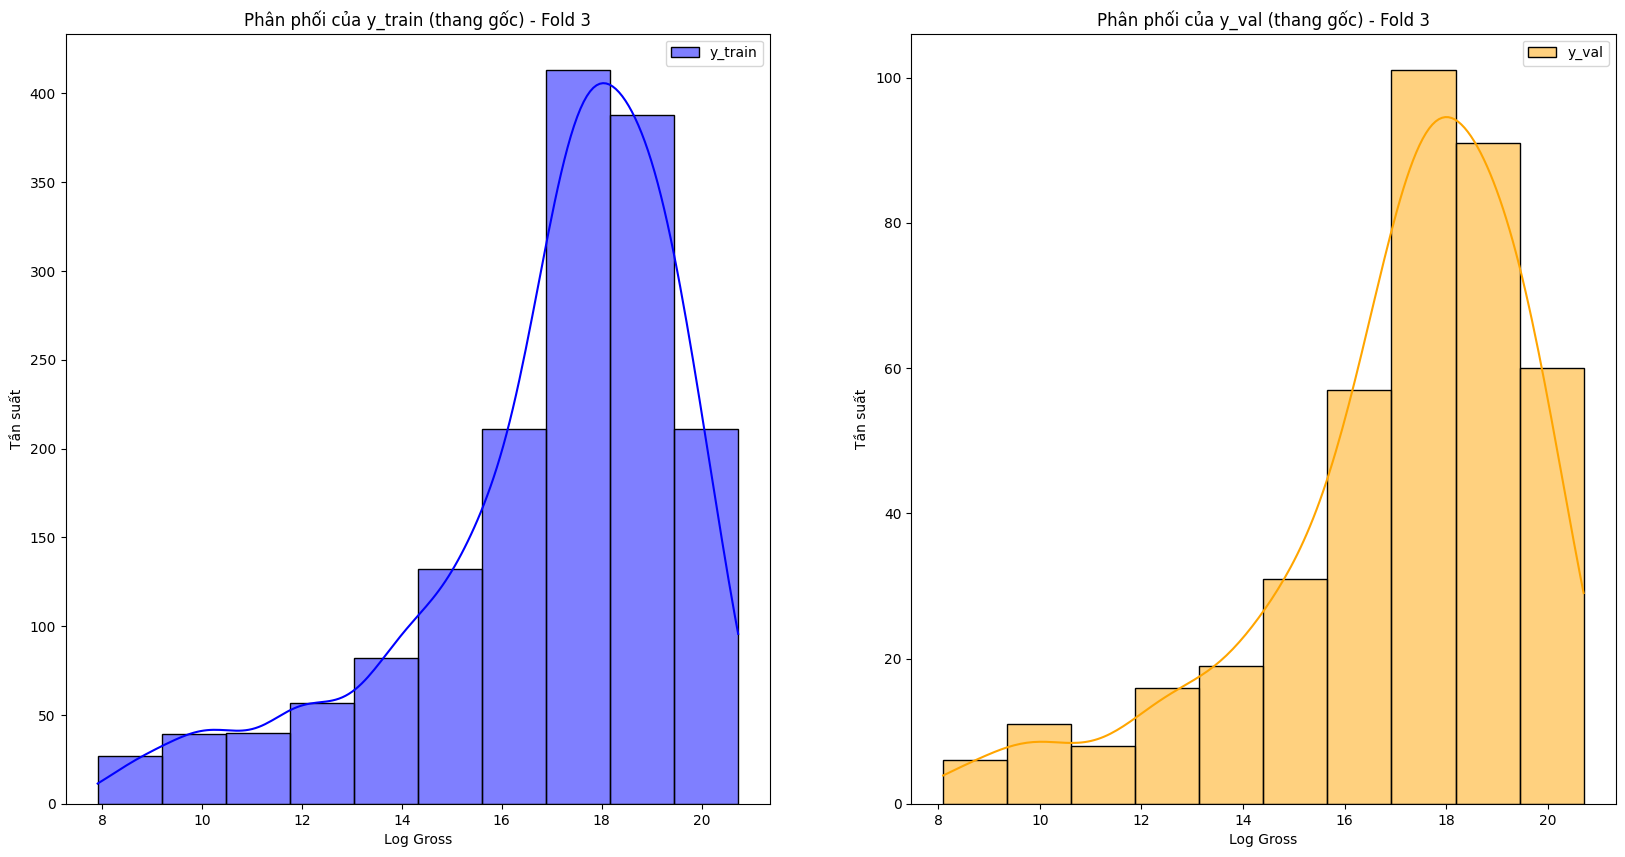

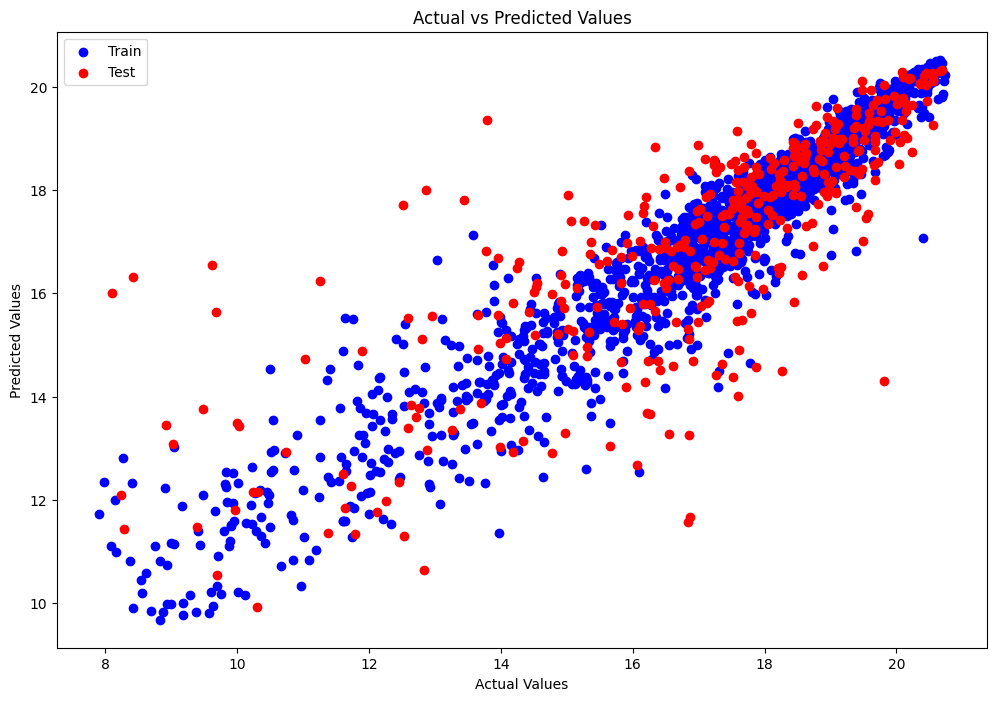

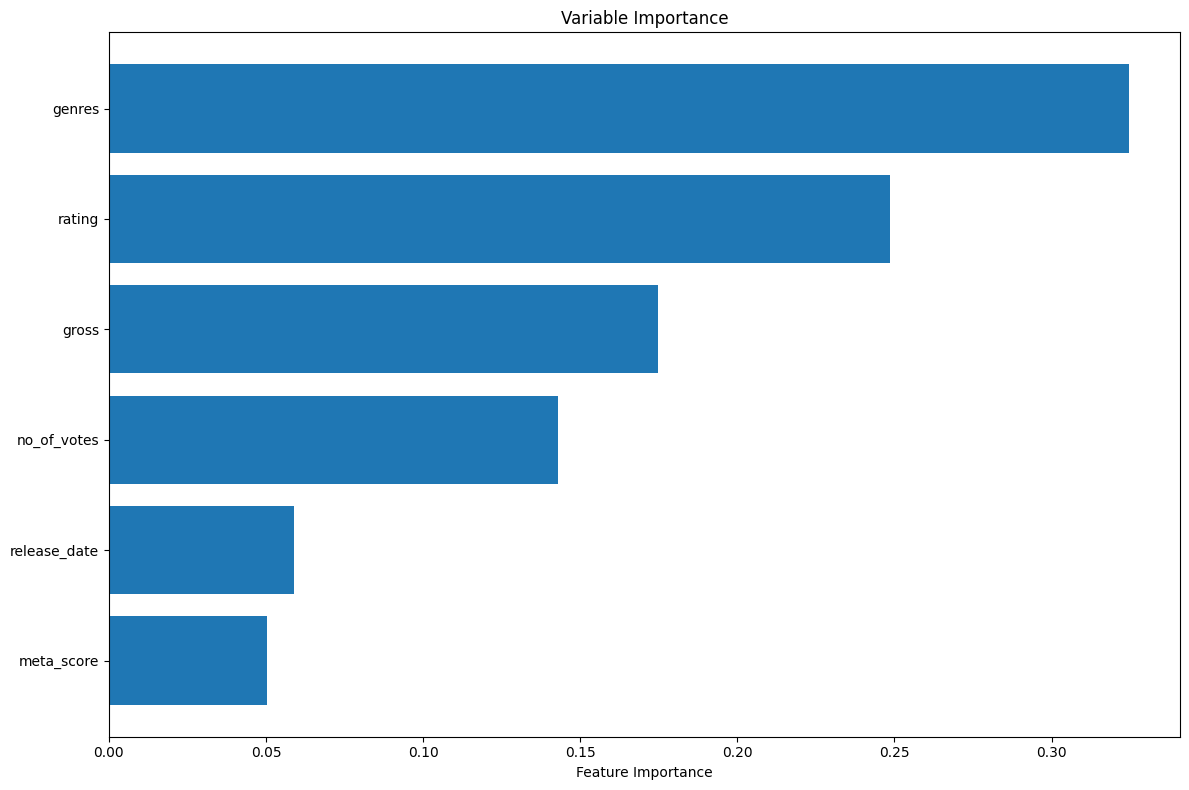


Fold 4
 Best hyperparameters: {'n_estimators': 155, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.545511410428418
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.7390
MAE: 47,964,890.3720
MAPE: 3.31%
Test Metrics
R2 score: 0.6011
MAE: 59,701,026.2738
MAPE: 11.15%


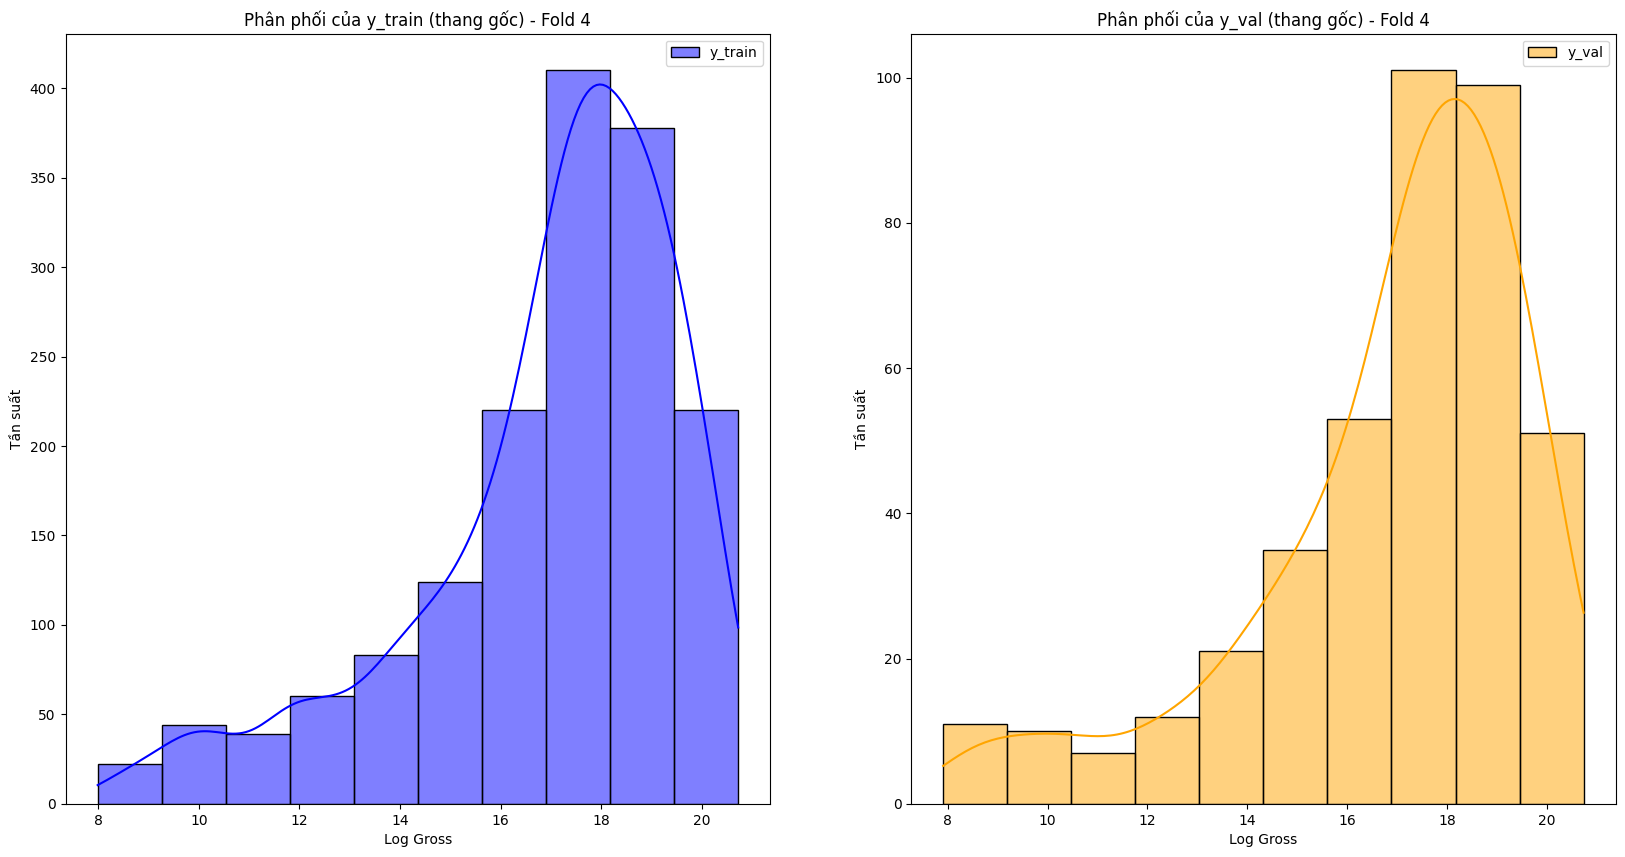

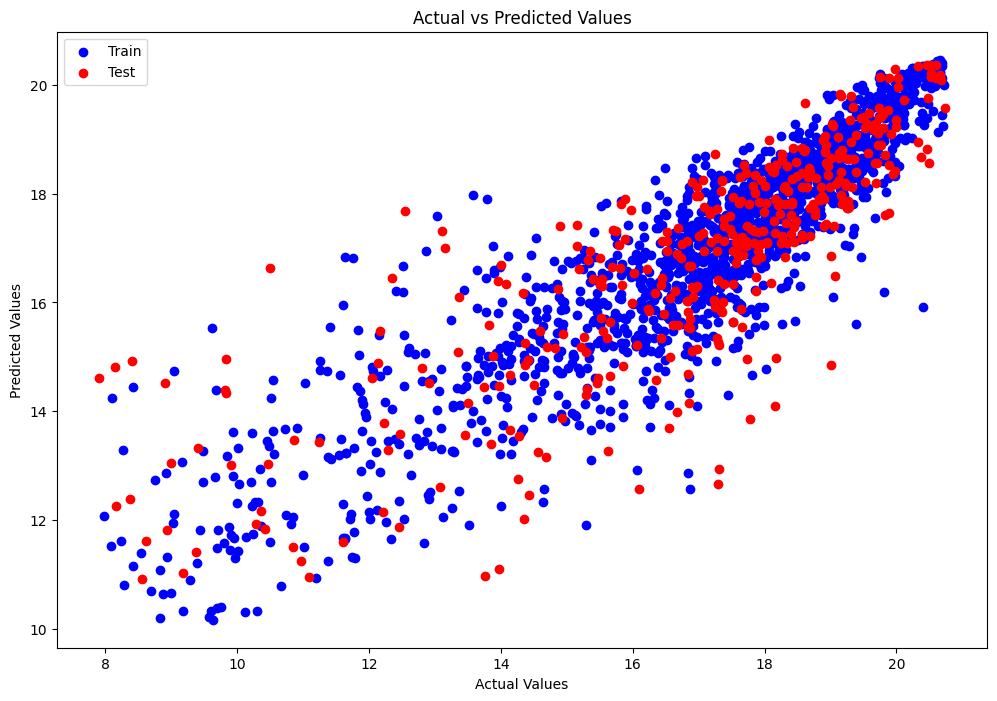

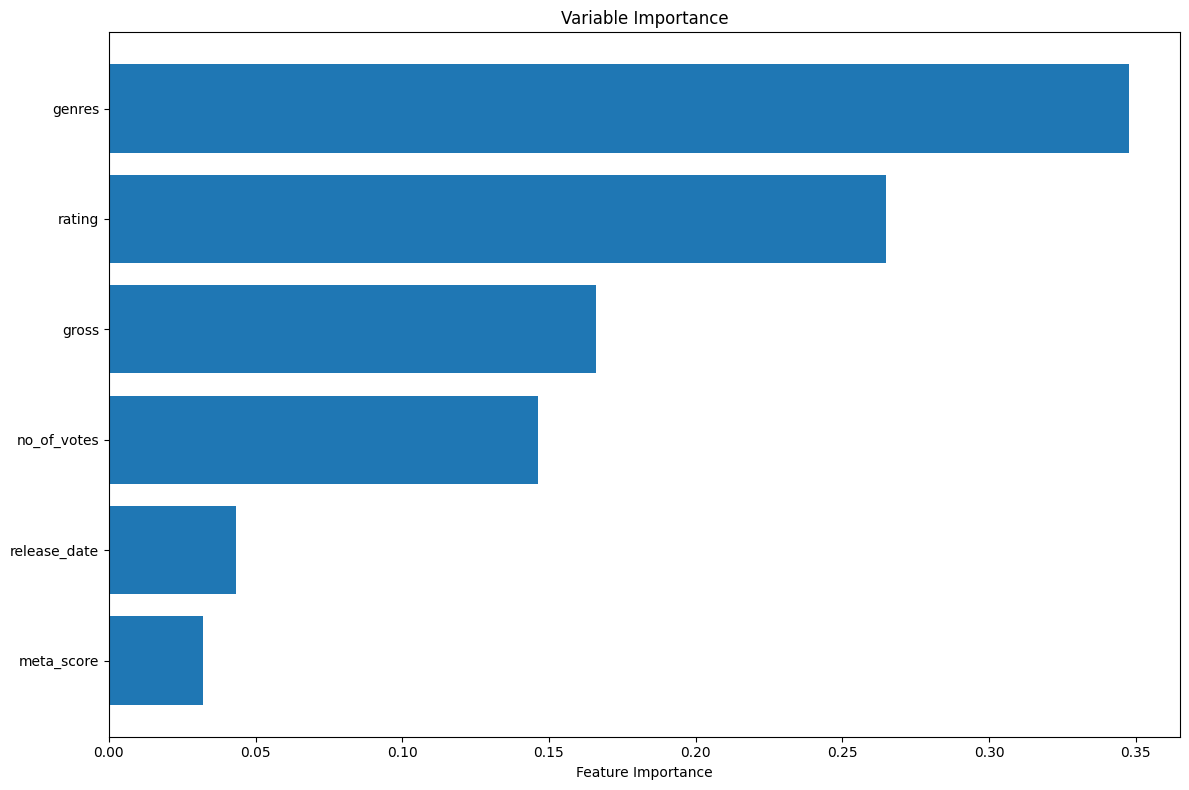


Fold 5
 Best hyperparameters: {'n_estimators': 384, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
 Best MSE: 2.6678312704250025
 Hiển thị quá trình tối ưu:


Training Metrics
R2 score: 0.8423
MAE: 35,440,662.2611
MAPE: 1.47%
Test Metrics
R2 score: 0.6086
MAE: 57,647,693.7211
MAPE: 4.94%


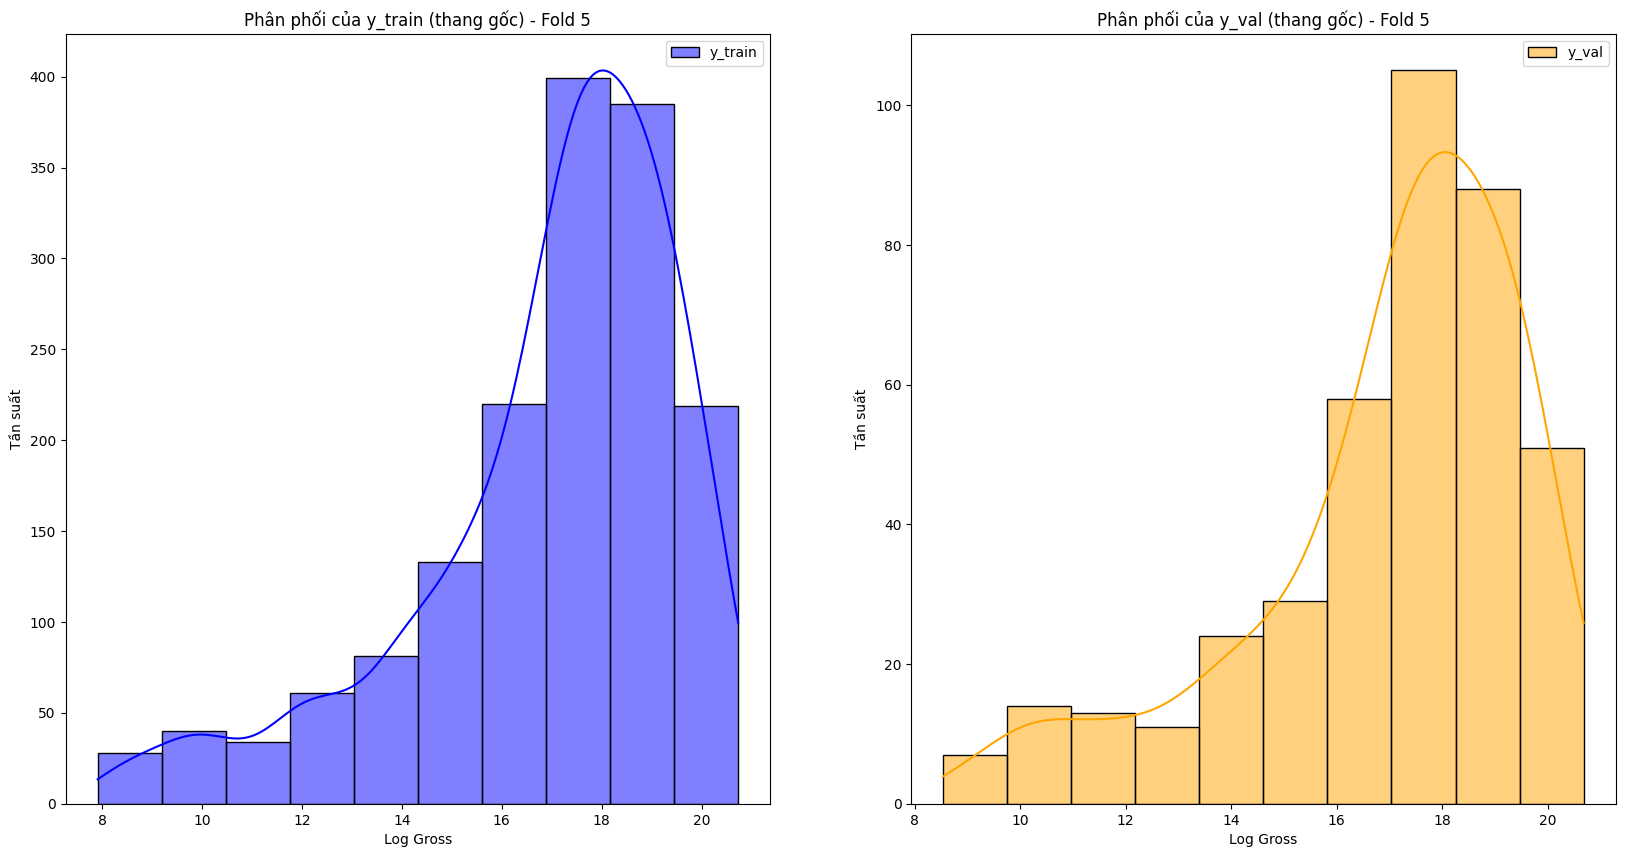

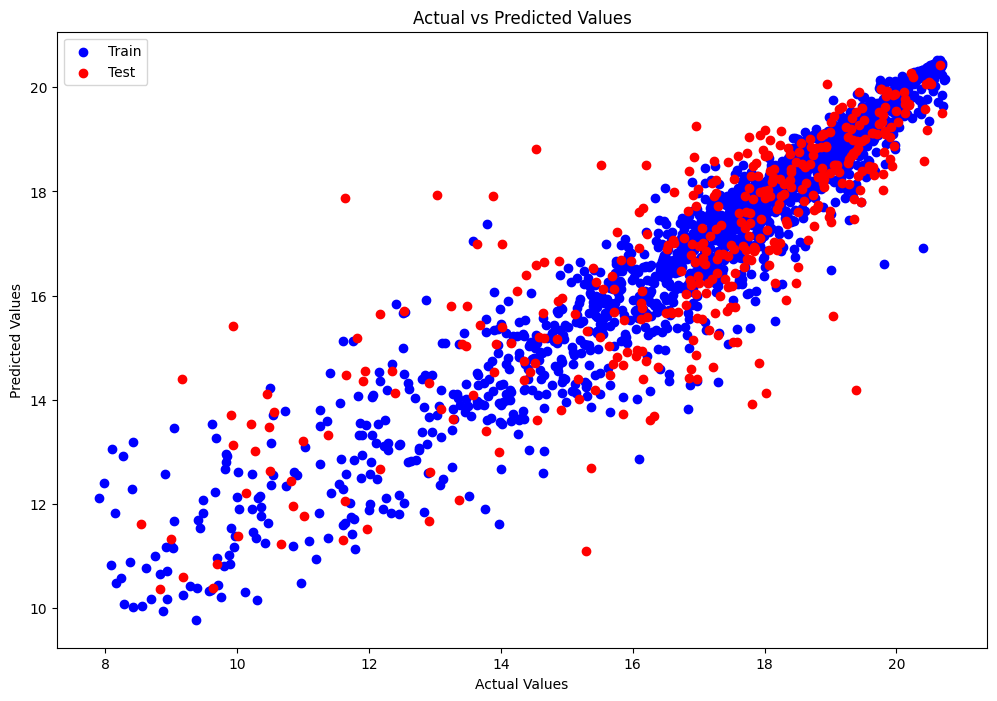

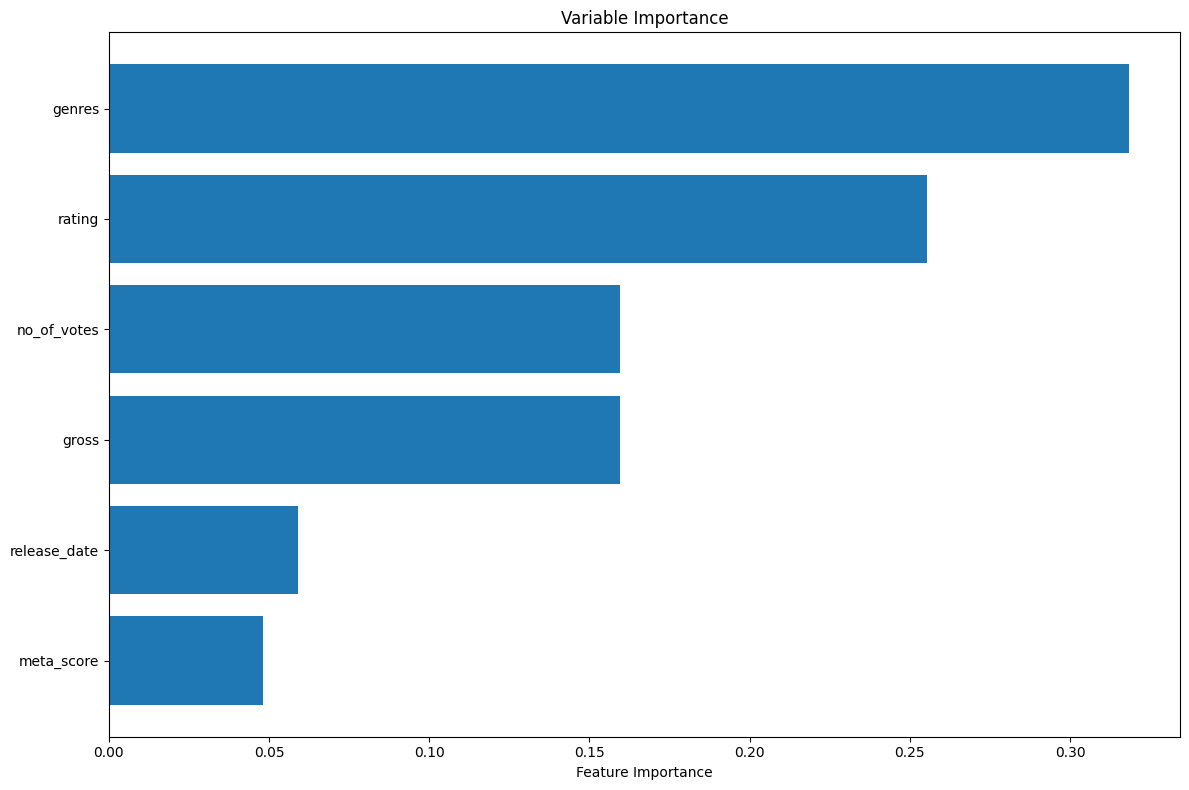

In [4]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from evaluation import visualize_results
import warnings

# warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['log_gross_bin'])):
    print(f"\nFold {fold + 1}")
    df_train = df.iloc[train_idx].copy()
    df_val = df.iloc[val_idx].copy()

    # Chọn đặc trưng đầu vào và mục tiêu
    #features = ['meta_score', 'rating', 'no_of_votes', 'budget', 'genre_stat_feature', 'country_stat_feature', 'release_date']
    features = ['no_of_votes', 'log_budget',
                'genre_stat_feature','country_stat_feature','rating','release_date']

    target = 'log_gross'

    X_train, y_train, X_val, y_val = processing_data(df_train, df_val, fold=fold,features=features, target=target,model_name="random_forest",directory="best_models")

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_categorical('max_depth', [5, 10, 20, None]),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            'max_features': trial.suggest_categorical('max_features', ['sqrt']),
            'bootstrap': trial.suggest_categorical('bootstrap', [True]),
            'random_state': 42,
            'n_jobs': -1
        }

        model = RandomForestRegressor(**params)
        score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=3).mean()
        return -score  # minimize MSE

    #  Tạo study với tên rõ ràng theo từng fold
    study = optuna.create_study(direction="minimize", study_name=f"Fold_{fold+1}_RandomForest")
    study.optimize(objective, n_trials=30)

    print(" Best hyperparameters:", study.best_params)
    print(" Best MSE:", study.best_value)

    best_model = RandomForestRegressor(**study.best_params, random_state=42, n_jobs=-1)
    best_model.fit(X_train, y_train)

    train_preds = best_model.predict(X_train)
    val_preds = best_model.predict(X_val)

    #  Vẽ biểu đồ tối ưu và tầm quan trọng tham số
    print(" Hiển thị quá trình tối ưu:")
    plot_optimization_history(study).show()
    plot_param_importances(study).show()

    visualize_results(
        y_train, train_preds,
        y_val, val_preds,
        model=best_model,
        df=df,
        calculate_real_target=True,
    )
